In [1]:
#==================================================
# Imports
#==================================================
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray
import datetime
import calendar
import matplotlib
import os
#import h5py
import PseudoNetCDF as pnc
from scipy.ndimage import label
import scipy.interpolate as interp
import pickle
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import h5py
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from scipy.integrate import cumulative_trapezoid as scitrapz

In [2]:
def toTimestamp(d):
    return calendar.timegm(d.timetuple())

# Read in Learjet data (bulk microphysics, state variables, and FFSSP probe), all publicly availble on the CAMP2Ex data portal (https://www-air.larc.nasa.gov/cgi-bin/ArcView/camp2ex)

In [3]:
path = '/discover/nobackup/mwstanfo/camp2ex_data/learjet/20190925/'
file_bulk_props = path+'CAMP2Ex-CloudBulkProps_Learjet_20190925_R0.ICT'
file_ffssp = path+'CAMP2Ex-FFSSP_Learjet_20190925_R0.ict'
file_state = path+'CAMP2Ex-Page0_Learjet_20190925_R0.ict'

In [4]:
start_date = datetime.datetime(2019,9,25)
twc_thresh = 1.e-1

In [5]:
def process_state_bulk(state_file_name,bulk_file_name,start_date):
    """
    Processes the Bulk and State files from the Learjet flight.
    """
    
    #===========================================
    # State file
    #===========================================

    infile = pnc.pncopen(state_file_name, format = 'ffi1001')
    var_list = infile.variables
    keys = list(var_list.keys())
    # Make Datetime arrays
    secs_from_00z = var_list['Time_Start'].data
    nt = len(secs_from_00z)
    time = np.array([start_date + datetime.timedelta(seconds=secs_from_00z[dd]) for dd in range(nt)])
    
    # Pull out state properties
    tas = var_list['TAS'].data # True air speed (m/s)
    pres_alt = var_list['Palt'].data # Pressure altitude (ft)
    temp = var_list['Temp'].data # temperature (C)
    dew = var_list['Dew'].data # dewpoint temperature (C)
    NevLWC = var_list['NevLWC'].data # Nevzorov LWC (g/m3)
    FSSPWC = var_list['FSSPWC'].data # FFSSP water content (g/m3)
    FCDPHWC = var_list['FCDPHWC'].data # Hawkeye-FCDP water content (g/m3)
    FCDPWC = var_list['FCDPWC'].data # FCDP water content (g/m3)
    NevTWC = var_list['NevTWC'].data # Nevzorov total water content (g/m3)
    VaV = var_list['VaV'].data # Vertical wind (updraft) (m/s)
    FSSPconc = var_list['FSSPConc'].data # FFSSP concentration (#/cc)
    FCDPHconc = var_list['FCDPHConc'].data # Hawkeye-FCDP concentration (#/cc)
    FCDPconc = var_list['FCDPConc'].data # FCDP concentration (#/cc)
    x2DSHsn10 = var_list['2DSHsn10'].data # SPEC 2D-S SN10 Concentration, H-channel (#/L)
    x2DSVsn10 = var_list['2DSVsn10'].data # SPEC 2D-S SN10 Concentration, V-channel (#/L)
    x2DSHNcar = var_list['2DSHNcar'].data # NCAR 2D-S Concentration, H-channel (#/L)
    x2DSVNcar = var_list['2DSVNcar'].data # NCAR 2D-S Concentration, V-channel (#/L)
    x2DS10Hawk = var_list['2DS10Hawk'].data # Hawkeye-2DS 10um channel concentration (#/L)
    x2DS50Hawk = var_list['2DS50Hawk'].data # Hawkeye-2DS 50um channel concentration (#/L)
    HVPS = var_list['HVPS'].data # HVPS concentration (#/L)
    CPC = var_list['CPC'].data # CPC concentration (#/cc)
    PCASP = var_list['PCASP'].data # PCASP concentration (#/cc)
    lat = var_list['Lat'].data
    lon = var_list['Long'].data
    rice = var_list['Rice'].data
    
    state_dict = {'pres_alt':pres_alt,\
                'temp':temp,\
                'dew':dew,\
                'tas':tas,\
                'alt':pres_alt*0.3048*1.e-3,\
                'NevLWC':NevLWC,\
                'FSSPWC':FSSPWC,\
                'FCDPHWC':FCDPHWC,\
                'FCDPWC':FCDPWC,\
                'NevTWC':NevTWC,\
                'VaV':VaV,\
                'FSSPconc':FSSPconc,\
                'FCDPHconc':FCDPHconc,\
                'FCDPconc':FCDPconc,\
                '2DSHsn10':x2DSHsn10,\
                '2DSVsn10':x2DSVsn10,\
                '2DSHNcar':x2DSHNcar,\
                '2DSVNcar':x2DSVNcar,\
                '2DS10Hawk':x2DS10Hawk,\
                '2DS50Hawk':x2DS50Hawk,\
                'HVPS':HVPS,\
                'CPC':CPC,\
                'PCASP':PCASP,\
                'time':time,\
                'lat':lat,\
                'lon':lon,\
                'rice':rice,\
               }
    
    
    #===========================================
    # Bulk Props File
    #===========================================    
    infile = pnc.pncopen(bulk_file_name, format = 'ffi1001')
    var_list = infile.variables
    keys = list(var_list.keys())

    # Make Datetime arrays
    secs_from_00z = var_list['Time_Start'].data
    nt = len(secs_from_00z)
    time = np.array([start_date + datetime.timedelta(seconds=secs_from_00z[dd]) for dd in range(nt)])

    cp_type = var_list['CP_Type'].data # (#), none, Cloud pass type, 1 = "Cloud" High Concentration of small particles (WC>0.1g/m3 for scatter probes in 1-50um range), 2 = "Precip" High Concentration of HVPS Particles (N>100/s), 3 = "Scud" Cloud Flag >0
    conc_L = var_list['Concentration_L'] #  (#/L), CldMicro_NumSizeDist_InSitu_Imaging_DroptoPrecip_AMB, Cloud-averaged composite total particle concentration from interpolated concentration PSD(1um-10mm)
    iwc = var_list['IWC_gm3'].data # (g/m3), CldMicro_TWC_InSitu_None_Bulk_AMB,  Cloud-averaged composite Ice water content (all particles treated as Ice) from interpolated concentration PSD (1um-10mm) using Brown and Francis 1995 method
    lwc = var_list['LWC_gm3'].data #  (g/m3), CldMicro_TWC_InSitu_None_Bulk_AMB, Cloud-averaged composite Liquid water content (all particles treated as liquid Rho = 1kg/L) from interpolated concentration PSD (1um-10mm) assuming all spherical particles
    reff = var_list['Reff_um'].data # (um),   CldMicro_MeanSize_InSitu_Imaging_DroptoPrecip_None, Cloud-averaged composite Effective Radius from interpolated concentration PSD (1um-10mm)
    ze = var_list['Z_dBz'].data # (dBz),  none, Cloud-averaged composite (Estimated) Radar Reflectivity from interpolated concentration PSD (1um-10mm)    
    
    
    bulk_dict = {'time':time,\
                 'lat':lat,\
                 'lon':lon,\
                 'cp_type':cp_type,\
                 'conc_L':conc_L,\
                 'iwc':iwc,\
                 'lwc':lwc,\
                 'reff':reff,\
                 'ze':ze}
        
    return state_dict,bulk_dict

# Create dictionaries holding bulk microphysical and state variable data from Learjet

In [6]:
state_dict,bulk_dict = process_state_bulk(file_state,file_bulk_props,start_date)

# Function to process FFSSP data and put in dictionary

In [7]:
def process_ffssp(file_name,start_date):
    infile_ffssp = pnc.pncopen(file_name, format = 'ffi1001')
    var_list = infile_ffssp.variables
    keys = list(var_list.keys())
    
    # Make Datetime arrays
    secs_from_00z = var_list['Time_Start'].data
    nt = len(secs_from_00z)
    time = np.array([start_date + datetime.timedelta(seconds=secs_from_00z[dd]) for dd in range(nt)])
    
    # Pull out bulk properties
    twc = var_list['twc'].data
    conc = var_list['conc'].data
    ext = var_list['ext'].data
    cnt = var_list['CNT'].data
    sv = var_list['sv'].data

        
    # Make a dictionary that holds the concentrations for each bin
    cbin_dict = {}
    for key in keys:
        if 'cbin' in key:
            cbin_dict[key] = var_list[key].data
            
    # Make a dictionary that holds the raw counts for each bin
    nbin_dict = {}
    for key in keys:
        if 'nbin' in key:
            nbin_dict[key] = var_list[key].data                
            
    sizes = [0,1.5,3,4.5,6,8,10,12,14,16,18,21,24,27,30,33,36,39,42,46,50]
    mid_sizes = np.array([0.5*(sizes[dd] + sizes[dd+1]) for dd in range(len(sizes)-1)])           
            
    var_dict = {'twc':twc,\
                'conc':conc,\
                'ext':ext,\
                'cbin_dict':cbin_dict,\
               'time':time,\
               'sizes':sizes,\
               'mid_sizes':mid_sizes}
        
    return var_dict


# Return FFSSP dictionary and process data further to calculate effective radius and variane

In [8]:
ffssp_dict = process_ffssp(file_ffssp,start_date)

state_alt = state_dict['alt']
state_time = state_dict['time']


ffssp_cbin_dict = ffssp_dict['cbin_dict']
ffssp_cloud_id = np.where(ffssp_dict['twc'] >= twc_thresh)[0]
ffssp_time = ffssp_dict['time'][ffssp_cloud_id]

ffssp_alt = []

for ii in range(len(ffssp_time)):
    dumid = np.where(state_time == ffssp_time[ii])[0]
    ffssp_alt.append(state_alt[dumid[0]])
ffssp_alt = np.array(ffssp_alt)


for key,val in ffssp_cbin_dict.items():
    ffssp_cbin_dict[key] = val[ffssp_cloud_id]
ffssp_dict['twc'] = ffssp_dict['twc'][ffssp_cloud_id]
ffssp_dict['ext'] = ffssp_dict['ext'][ffssp_cloud_id]
ffssp_dict['conc'] = ffssp_dict['conc'][ffssp_cloud_id]
ffssp_dict['time'] = ffssp_time
ffssp_dict['alt'] = ffssp_alt
    
ffssp_dsd = []

for ii in range(len(ffssp_cloud_id)):
    dum_arr = []
    for key in ffssp_cbin_dict.keys():
        dum_arr.append(ffssp_cbin_dict[key][ii])
    dum_arr = np.array(dum_arr)
    ffssp_dsd.append(dum_arr)
ffssp_dsd = np.array(ffssp_dsd)   

ffssp_sizes = ffssp_dict['sizes']
ffssp_mid_sizes = ffssp_dict['mid_sizes']
size_diff = np.diff(ffssp_sizes)
rad_size_diff = size_diff/2.


ffssp_reff = []
ffssp_veff = []

for ii in range(len(ffssp_cloud_id)):
    dum_dsd = ffssp_dsd[ii,:] # #/m3/um
    r4 = np.trapezoid(dum_dsd[0:-1]*((ffssp_mid_sizes/2.)**4.),ffssp_mid_sizes/2.)
    r3 = np.trapezoid(dum_dsd[0:-1]*((ffssp_mid_sizes/2.)**3.),ffssp_mid_sizes/2.)
    r2 = np.trapezoid(dum_dsd[0:-1]*((ffssp_mid_sizes/2.)**2.),ffssp_mid_sizes/2.)

    #r3_cumu = scitrapz(dum_dsd[0:-1]*((ffssp_mid_sizes/2.)**3.),ffssp_mid_sizes/2.,initial=0)
    #r2_cumu = scitrapz(dum_dsd[0:-1]*((ffssp_mid_sizes/2.)**2.),ffssp_mid_sizes/2.,initial=0)
    
    
    tmp_reff = r3/r2 # um
    #tmp_reff_cumu = r3_cumu/r2_cumu # um
    #tmp_reff = tmp_reff*1.e-6 # m
    #tmp_reff_cumu = tmp_reff_cumu*1.e-6 # m
    #tmp_reff_cumu[np.isnan(tmp_reff_cumu)] = 0.

    tmp_ffssp_mid_sizes = ffssp_mid_sizes*1.e-6/2. # m in radius
    tmp_dum_dsd = dum_dsd[0:-1]*size_diff/rad_size_diff*1.e6 # #/m4 normalized by radius width instead of diameter width

    tmp_veff = (r4*r2)/(r3**2.)-1.

    ffssp_reff.append(tmp_reff)
    ffssp_veff.append(tmp_veff)

ffssp_reff = np.array(ffssp_reff)
ffssp_veff = np.array(ffssp_veff)
ffssp_dict['reff'] = ffssp_reff
ffssp_dict['veff'] = ffssp_veff


# Define Height Bins

In [9]:
height_bins = np.arange(0,8000,1000)*1.e-3
#height_bins = np.arange(0,7500,500)*1.e-3
#height_bins = np.arange(500,8500,1000)*1.e-3
height_midbins = np.array([(height_bins[dd]+height_bins[dd+1])/2. for dd in range(len(height_bins)-1)])

# Calculate in situ percentiles of Nd and Reff for height bins

In [10]:
#======================================================
# Calculate percentages for FFSSP
#======================================================

tmp_keys = ['alt','conc','reff','veff']
tmp_keys2 = ['mean','5','10','25','50','75','90','95']

ffssp_perc_dict = {}
for tmp_key in tmp_keys:
    ffssp_perc_dict[tmp_key] = {}
    for tmp_key2 in tmp_keys2:
        ffssp_perc_dict[tmp_key][tmp_key2] = []

alt = ffssp_dict['alt']



samp_size_vert = []
ffssp_samp_size = 0.
for kk in range(len(height_bins)-1):
    dumid = np.where( (alt >= height_bins[kk]) & (alt < height_bins[kk+1]) )
    dumfrac = np.size(dumid)/np.size(alt)
    samp_size_vert.append(np.size(dumid))
    if np.size(dumid) > 1.:
        ffssp_samp_size = ffssp_samp_size + np.size(dumid)
    for tmp_key in tmp_keys:
        #if dumfrac < 0.001:
        if np.size(dumid) < 1.:
            for tmp_key2 in tmp_keys2:
                if tmp_key2 == 'mean':
                    ffssp_perc_dict[tmp_key][tmp_key2].append(np.mean(ffssp_dict[tmp_key][dumid]))
                else:
                    ffssp_perc_dict[tmp_key][tmp_key2].append(np.nan)          
            continue
        else:
            ffssp_perc_dict[tmp_key]['mean'].append(np.mean(ffssp_dict[tmp_key][dumid]))
            ffssp_perc_dict[tmp_key]['25'].append(np.percentile(ffssp_dict[tmp_key][dumid],25))
            ffssp_perc_dict[tmp_key]['50'].append(np.percentile(ffssp_dict[tmp_key][dumid],50))
            ffssp_perc_dict[tmp_key]['75'].append(np.percentile(ffssp_dict[tmp_key][dumid],75))
            ffssp_perc_dict[tmp_key]['90'].append(np.percentile(ffssp_dict[tmp_key][dumid],90))
            ffssp_perc_dict[tmp_key]['10'].append(np.percentile(ffssp_dict[tmp_key][dumid],10))
            ffssp_perc_dict[tmp_key]['95'].append(np.percentile(ffssp_dict[tmp_key][dumid],95))
            ffssp_perc_dict[tmp_key]['5'].append(np.percentile(ffssp_dict[tmp_key][dumid],5))
    


for tmp_key in tmp_keys:
    for tmp_key2 in tmp_keys2:
        ffssp_perc_dict[tmp_key][tmp_key2] = np.array(ffssp_perc_dict[tmp_key][tmp_key2])




# Calculate in situ percentile profiles of Nevzorov LWC

In [11]:
tmp_keys = ['alt','NevLWC','FSSPWC','NevTWC']
tmp_keys2 = ['mean','5','10','25','50','75','90','95']

state_perc_dict = {}
for tmp_key in tmp_keys:
    state_perc_dict[tmp_key] = {}
    for tmp_key2 in tmp_keys2:
        state_perc_dict[tmp_key][tmp_key2] = []

alt = state_dict['alt']
min_thresh = 0.1 # g/m3

state_samp_size_vert = {'NevLWC':[],'FSSPWC':[],'NevTWC':[]}
for kk in range(len(height_bins)-1):
    for tmp_key in tmp_keys:
        dumid = np.where( (alt >= height_bins[kk]) & (alt < height_bins[kk+1]) & (state_dict[tmp_key] >= min_thresh) )
        
        if tmp_key != 'alt':
            state_samp_size_vert[tmp_key].append(np.size(dumid))
        if np.size(dumid) < 10.:
            for tmp_key2 in tmp_keys2:
                if tmp_key2 == 'mean':
                    state_perc_dict[tmp_key][tmp_key2].append(np.mean(state_dict[tmp_key][dumid]))
                else:
                    state_perc_dict[tmp_key][tmp_key2].append(np.nan)          
            continue
        else:
            state_perc_dict[tmp_key]['mean'].append(np.mean(state_dict[tmp_key][dumid]))
            state_perc_dict[tmp_key]['25'].append(np.percentile(state_dict[tmp_key][dumid],25))
            state_perc_dict[tmp_key]['50'].append(np.percentile(state_dict[tmp_key][dumid],50))
            state_perc_dict[tmp_key]['75'].append(np.percentile(state_dict[tmp_key][dumid],75))
            state_perc_dict[tmp_key]['90'].append(np.percentile(state_dict[tmp_key][dumid],90))
            state_perc_dict[tmp_key]['10'].append(np.percentile(state_dict[tmp_key][dumid],10))
            state_perc_dict[tmp_key]['95'].append(np.percentile(state_dict[tmp_key][dumid],95))
            state_perc_dict[tmp_key]['5'].append(np.percentile(state_dict[tmp_key][dumid],5))
    


for tmp_key in tmp_keys:
    for tmp_key2 in tmp_keys2:
        state_perc_dict[tmp_key][tmp_key2] = np.array(state_perc_dict[tmp_key][tmp_key2])




# Read in RSP files, also publicly availble on the CAMP2Ex data portal, and calculate percentiles of Nd and Reff for height bins

In [12]:
# RSP files
path = '/discover/nobackup/mwstanfo/camp2ex_data/rsp/20190925/v2/'
base_time = datetime.datetime(2019,9,25)

files = sorted(glob.glob(path+'*.h5'))
num_files = len(files)
print('# of RSP files:',num_files)

infile = h5py.File(files[0],"r")
keys_list = list(infile.keys())
data = infile['Data']

time_arr = []
cth_arr = []
ctt_arr = []
Reff_arr = []
ve_arr = []
tau_arr = []
phase_arr = []
nd_arr = []
lwp_arr = []
cloud_test_arr = []


for tt in range(num_files):
    
    file_name = files[tt]
    file_time = file_name.split('/')[-1]
    file_time = file_time.split('.')[0]
    file_time = file_time.split('_')[-2]
    

    infile = h5py.File(file_name,"r")
    keys_list = list(infile.keys())
    data = infile['Data']
    geom = infile['Geometry']
    time_secs = np.array(data['Product_Time_Seconds'])# seconds after midnight
    # Convert to datetimes
    time = np.array([base_time + datetime.timedelta(seconds=time_secs[dd]) for dd in range(len(time_secs))])
    #alt = np.array(geom['Collocated_Altitude'])
    cloud_test_passed = np.squeeze(np.array(data['Cloud_Test_Passed']))
    cloud_top_alt = np.array(data['Cloud_Top_Altitude'])[0,:]
    cloud_top_temp = np.array(data['Cloud_Top_Temperature'])
    #print(np.shape(cloud_top_temp))
    cloud_liquid_index = np.array(data['Cloud_Liquid_Index'])[:,0]
    #print(np.shape(cloud_liquid_index))
    #print(aaaa)
    cloud_bow_optical_thickness = np.array(data['Cloud_Bow_Optical_Thickness'])
    cloud_bow_droplet_effective_radius = np.array(data['Cloud_Bow_Droplet_Effective_Radius'])
    cloud_bow_droplet_effective_variance = np.array(data['Cloud_Bow_Droplet_Effective_Variance'])
    cloud_bow_droplet_number_concentration_adiabatic = np.array(data['Cloud_Bow_Droplet_Number_Concentration_Adiabatic'])
    cloud_bow_liquid_water_path = np.array(data['Cloud_Bow_Liquid_Water_Path'])
    
    time_arr.append(time)
    cth_arr.append(cloud_top_alt)
    Reff_arr.append(cloud_bow_droplet_effective_radius)
    ve_arr.append(cloud_bow_droplet_effective_variance)
    tau_arr.append(cloud_bow_optical_thickness)
    phase_arr.append(cloud_liquid_index)
    cloud_test_arr.append(cloud_test_passed)
    nd_arr.append(cloud_bow_droplet_number_concentration_adiabatic)
    lwp_arr.append(cloud_bow_liquid_water_path)
    ctt_arr.append(cloud_top_temp)
    
time_arr = np.array(time_arr,dtype=object)
cth_arr = np.array(cth_arr,dtype=object)
ctt_arr = np.array(ctt_arr,dtype=object)
Reff_arr = np.array(Reff_arr,dtype=object)
ve_arr = np.array(ve_arr,dtype=object)
tau_arr = np.array(tau_arr,dtype=object)
phase_arr = np.array(phase_arr,dtype=object)
cloud_test_arr = np.array(cloud_test_arr,dtype=object)
nd_arr = np.array(nd_arr,dtype=object)
lwp_arr = np.array(lwp_arr,dtype=object)

time_arr = np.concatenate(time_arr,axis=0)
cth_arr = np.concatenate(cth_arr,axis=0)
ctt_arr = np.concatenate(ctt_arr,axis=0)
tau_arr = np.concatenate(tau_arr,axis=0)
Reff_arr = np.concatenate(Reff_arr,axis=0)
ve_arr = np.concatenate(ve_arr,axis=0)
phase_arr = np.concatenate(phase_arr,axis=0)
cloud_test_arr = np.concatenate(cloud_test_arr,axis=0)
nd_arr = np.concatenate(nd_arr,axis=0)
lwp_arr = np.concatenate(lwp_arr,axis=0)



var_dict = {'time':time_arr,\
            'cth':cth_arr,\
            'ctt':ctt_arr,\
            'Reff':Reff_arr,\
            've':ve_arr,\
            'tau':tau_arr,\
            'phase':phase_arr,\
            'nd':nd_arr,\
            'lwp':lwp_arr,\
            'cloud_test':cloud_test_arr}

if True:
    dumid = np.where((var_dict['nd'] > -999.) & (var_dict['cth'] > 0.))# & (var_dict['phase'] <= 0.3) )[0]
    #dumid = np.where((var_dict['nd'] > -999.) & (var_dict['cth'] > 0.) & (var_dict['tau'] > 1.) )[0]
    for key,val in var_dict.items():
        var_dict[key] = val[dumid]

        
        
        
tmp_keys = ['cth','Reff','ve','tau','nd','lwp','ctt']
tmp_keys2 = ['mean','25','50','75','10','90','5','95']

rsp_ct_perc_dict = {}
for tmp_key in tmp_keys:
    rsp_ct_perc_dict[tmp_key] = {}
    for tmp_key2 in tmp_keys2:
        rsp_ct_perc_dict[tmp_key][tmp_key2] = []

cth = var_dict['cth']*1.e-3
tau = var_dict['tau']

samp_size_vert = []

cth_filter_arr = []
nd_filter_arr = []
Reff_filter_arr = []
ve_filter_arr = []
lwp_filter_arr = []
tau_filter_arr = []
rsp_samp_size = 0.
for kk in range(len(height_bins)-1):
    dumid = np.where( (cth >= height_bins[kk]) & (cth < height_bins[kk+1]) )
    #dumid = np.where( (cth >= height_bins[kk]) & (cth < height_bins[kk+1]) & (tau > 10.) )
    dumfrac = np.size(dumid)/np.size(cth)
    samp_size_vert.append(np.size(dumid))
    if np.size(dumid) > 10.:
        rsp_samp_size = rsp_samp_size + np.size(dumid)
        
    for tmp_key in tmp_keys:
        #print(tmp_key)
        #if dumfrac < 0.001:
        if np.size(dumid) < 10:
            for tmp_key2 in tmp_keys2:
                if tmp_key != 'ctt':
                    rsp_ct_perc_dict[tmp_key][tmp_key2].append(np.nan)
                else:
                    if tmp_key2 == 'mean':
                        if np.size(dumid) > 0.:
                            rsp_ct_perc_dict[tmp_key][tmp_key2].append(np.mean(var_dict[tmp_key][dumid]))
                        elif np.size(dumid) == 0.:
                            dumid2 = np.where( (cth >= height_bins[kk]) & (cth < height_bins[kk+1]))
                            rsp_ct_perc_dict[tmp_key][tmp_key2].append(np.mean(var_dict[tmp_key][dumid2]))
                    else:
                        rsp_ct_perc_dict[tmp_key][tmp_key2].append(np.nan)
                    
            continue
        else:
            rsp_ct_perc_dict[tmp_key]['mean'].append(np.mean(var_dict[tmp_key][dumid]))
            rsp_ct_perc_dict[tmp_key]['25'].append(np.percentile(var_dict[tmp_key][dumid],25))
            rsp_ct_perc_dict[tmp_key]['50'].append(np.percentile(var_dict[tmp_key][dumid],50))
            rsp_ct_perc_dict[tmp_key]['75'].append(np.percentile(var_dict[tmp_key][dumid],75))
            rsp_ct_perc_dict[tmp_key]['90'].append(np.percentile(var_dict[tmp_key][dumid],90))
            rsp_ct_perc_dict[tmp_key]['10'].append(np.percentile(var_dict[tmp_key][dumid],10))
            rsp_ct_perc_dict[tmp_key]['95'].append(np.percentile(var_dict[tmp_key][dumid],95))
            rsp_ct_perc_dict[tmp_key]['5'].append(np.percentile(var_dict[tmp_key][dumid],5))
            if tmp_key == 'nd':
                nd_filter_arr.append(var_dict[tmp_key][dumid])
            if tmp_key == 'Reff':
                Reff_filter_arr.append(var_dict[tmp_key][dumid])
            if tmp_key == 've':
                ve_filter_arr.append(var_dict[tmp_key][dumid])
            if tmp_key == 'cth':
                cth_filter_arr.append(var_dict[tmp_key][dumid])
            if tmp_key == 'lwp':
                lwp_filter_arr.append(var_dict[tmp_key][dumid])
            if tmp_key == 'tau':
                tau_filter_arr.append(var_dict[tmp_key][dumid])
for tmp_key in tmp_keys:
    for tmp_key2 in tmp_keys2:
        rsp_ct_perc_dict[tmp_key][tmp_key2] = np.array(rsp_ct_perc_dict[tmp_key][tmp_key2])


rsp_ctt_mean = rsp_ct_perc_dict['ctt']['mean']-273.15


# Linearly interpolate ctt_mean to height_bins

rsp_ctt_mean_interp = np.interp(height_bins,height_midbins,rsp_ctt_mean)
rsp_qn_mean_interp = np.interp(height_bins,height_midbins,rsp_ct_perc_dict['nd']['mean'])
rsp_reff_l_mean_interp = np.interp(height_bins,height_midbins,rsp_ct_perc_dict['Reff']['mean'])
rsp_lwp_mean_interp = np.interp(height_bins,height_midbins,rsp_ct_perc_dict['lwp']['mean'])
rsp_ve_mean_interp = np.interp(height_bins,height_midbins,rsp_ct_perc_dict['ve']['mean'])

nd_filter_arr = np.concatenate(nd_filter_arr)
Reff_filter_arr = np.concatenate(Reff_filter_arr)
cth_filter_arr = np.concatenate(cth_filter_arr)
lwp_filter_arr = np.concatenate(lwp_filter_arr)
tau_filter_arr = np.concatenate(tau_filter_arr)
ve_filter_arr = np.concatenate(ve_filter_arr)


# of RSP files: 27


/gpfsm/dnb33/tdirs/batch/slurm.42931965.mwstanfo/ipykernel_43113/2016955255.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  time_secs = np.array(data['Product_Time_Seconds'])# seconds after midnight
/gpfsm/dnb33/tdirs/batch/slurm.42931965.mwstanfo/ipykernel_43113/2016955255.py:41: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cloud_test_passed = np.squeeze(np.array(data['Cloud_Test_Passed']))
/gpfsm/dnb33/tdirs/batch/slurm.42931965.mwstanfo/ipykernel_43113/2016955255.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cloud_top_alt = np.array(data['Cloud_Top_Altitude'])[0,:]
/gpfsm/dnb33/tdirs/batch/slurm.429319

# Make some functions to help create legend for following plot

In [13]:
from matplotlib.collections import PatchCollection

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors,edgecolor):
        self.colors = colors
        self.edgecolor = edgecolor
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor=orig_handle.edgecolor))

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch

# Read in dictionaries holding cloud-top variables from the DHARMA CNTL and BIN_TURB_10X simulations
## Complete 3D data for the CNTL simulation are available on the NCCS Data Portal (https://portal.nccs.nasa.gov/datashare/giss-camp2ex/)
## 3D output from the BIN_TURB_10X simulation is very large, but can be made available upon request
## Cloud-top calculations can be recreated following the methodology in the manuscript (Section 4.3)

In [14]:
sim_name = 'cntl'
bin_sim_name = 'bin_turb_10x'

load_path = '/discover/nobackup/mwstanfo/dharma_post/cloud_top/'
#file_name = load_path+sim_name+'_2D_dict_9-12hrs.p'
file_name = load_path+sim_name+'_2D_dict_9-12hrs_v3.p'
#file_name = load_path+sim_name+'_2D_dict_1-12hrs.p'
#file_name = load_path+sim_name+'_2D_dict_6-9hrs.p'
#file_name = load_path+sim_name+'_2D_dict_6-12hrs.p'
all_dict_ct = pickle.load(open(file_name,'rb'))

#load_path = '/discover/nobackup/mwstanfo/dharma_post/cloud_top/old/'
load_path = '/discover/nobackup/mwstanfo/dharma_post/cloud_top/'
#bin_file_name = load_path+bin_sim_name+'_2D_dict_9-12hrs.p'
bin_file_name = load_path+bin_sim_name+'_2D_dict_9-12hrs_v3.p'
bin_all_dict_ct = pickle.load(open(bin_file_name,'rb'))

In [15]:
#=========================================
# Create a filtered dictionary for only
# points w/ CTH > 0.
#=========================================

# Bulk
all_dict_ct_filter = all_dict_ct.copy()
dum_ct_qrain = all_dict_ct_filter['ct_qrain'].copy()
dum_ct_rho = all_dict_ct_filter['ct_rho'].copy()
dum_ct_qrain = dum_ct_qrain*dum_ct_rho*1.e3
dumid = np.where(all_dict_ct_filter['cth'] > 0.)
all_dict_ct_filter['cth'] = all_dict_ct_filter['cth'][dumid]
all_dict_ct_filter['ctt'] = all_dict_ct_filter['ctt'][dumid]
all_dict_ct_filter['lwp'] = all_dict_ct_filter['lwp'][dumid]
all_dict_ct_filter['clwp'] = all_dict_ct_filter['clwp'][dumid]
all_dict_ct_filter['ct_qcloud'] = all_dict_ct_filter['ct_qcloud'][dumid]
all_dict_ct_filter['ct_ql'] = all_dict_ct_filter['ct_ql'][dumid]
all_dict_ct_filter['ct_qrain'] = all_dict_ct_filter['ct_qrain'][dumid]
all_dict_ct_filter['ct_qnl'] = all_dict_ct_filter['ct_qnl'][dumid]
all_dict_ct_filter['ct_qnl_lt_100um'] = all_dict_ct_filter['ct_qnl_lt_100um'][dumid]
all_dict_ct_filter['ct_qnl_lt_200um'] = all_dict_ct_filter['ct_qnl_lt_200um'][dumid]
all_dict_ct_filter['ct_qncloud'] = all_dict_ct_filter['ct_qncloud'][dumid]
all_dict_ct_filter['ct_qnrain'] = all_dict_ct_filter['ct_qnrain'][dumid]
all_dict_ct_filter['ct_reff_c'] = all_dict_ct_filter['ct_reff_c'][dumid]
all_dict_ct_filter['ct_reff_c_int'] = all_dict_ct_filter['ct_reff_c_int'][dumid]
all_dict_ct_filter['ct_veff_c_int'] = all_dict_ct_filter['ct_veff_c_int'][dumid]
all_dict_ct_filter['ct_reff_l'] = all_dict_ct_filter['ct_reff_l'][dumid]
all_dict_ct_filter['ct_veff_l'] = all_dict_ct_filter['ct_veff_l'][dumid]
all_dict_ct_filter['ct_reff_l_lt_100um'] = all_dict_ct_filter['ct_reff_l_lt_100um'][dumid]
all_dict_ct_filter['ct_veff_l_lt_100um'] = all_dict_ct_filter['ct_veff_l_lt_100um'][dumid]
all_dict_ct_filter['ct_reff_l_lt_200um'] = all_dict_ct_filter['ct_reff_l_lt_200um'][dumid]
all_dict_ct_filter['ct_veff_l_lt_200um'] = all_dict_ct_filter['ct_veff_l_lt_200um'][dumid]
all_dict_ct_filter['op_thick'] = all_dict_ct_filter['op_thick'][dumid]
all_dict_ct_filter['ct_rho'] = all_dict_ct_filter['ct_rho'][dumid]

# Bin
bin_all_dict_ct_filter = bin_all_dict_ct.copy()
dumid = np.where(bin_all_dict_ct_filter['cth'] > 0.)
bin_all_dict_ct_filter['cth'] = bin_all_dict_ct_filter['cth'][dumid]
bin_all_dict_ct_filter['ctt'] = bin_all_dict_ct_filter['ctt'][dumid]
bin_all_dict_ct_filter['lwp'] = bin_all_dict_ct_filter['lwp'][dumid]
bin_all_dict_ct_filter['ct_ql'] = bin_all_dict_ct_filter['ct_ql'][dumid]
bin_all_dict_ct_filter['ct_qnl'] = bin_all_dict_ct_filter['ct_qnl'][dumid]
bin_all_dict_ct_filter['ct_qnl_lt_100um'] = bin_all_dict_ct_filter['ct_qnl_lt_100um'][dumid]
bin_all_dict_ct_filter['ct_qnl_lt_200um'] = bin_all_dict_ct_filter['ct_qnl_lt_200um'][dumid]
bin_all_dict_ct_filter['ct_reff_l'] = bin_all_dict_ct_filter['ct_reff_l'][dumid]
bin_all_dict_ct_filter['ct_reff_l_lt_100um'] = bin_all_dict_ct_filter['ct_reff_l_lt_100um'][dumid]
bin_all_dict_ct_filter['ct_reff_l_lt_200um'] = bin_all_dict_ct_filter['ct_reff_l_lt_200um'][dumid]
bin_all_dict_ct_filter['ct_veff_l'] = bin_all_dict_ct_filter['ct_veff_l'][dumid]
bin_all_dict_ct_filter['ct_veff_l_lt_100um'] = bin_all_dict_ct_filter['ct_veff_l_lt_100um'][dumid]
bin_all_dict_ct_filter['ct_veff_l_lt_200um'] = bin_all_dict_ct_filter['ct_veff_l_lt_200um'][dumid]
bin_all_dict_ct_filter['ct_reff_op_thick'] = bin_all_dict_ct_filter['op_thick'][dumid]

# Calculate percentiles of Nd and Reff for height bins for the bulk scheme (CNTL)

In [16]:
#=======================================================
# Bulk
#=======================================================
tmp_keys = ['cth','ctt','ct_qncloud','ct_qnl','ct_reff_c','ct_reff_c_int','ct_reff_l','ct_reff_l_lt_100um','ct_reff_l_lt_200um','ct_qnl_lt_100um',\
           'ct_qnl_lt_200um','lwp','clwp','ct_veff_c_int','ct_veff_l','ct_veff_l_lt_100um','ct_veff_l_lt_200um']
tmp_keys2 = ['mean','5','10','25','50','75','90','95']

ct_perc_dict = {}
for tmp_key in tmp_keys:
    ct_perc_dict[tmp_key] = {}
    for tmp_key2 in tmp_keys2:
        ct_perc_dict[tmp_key][tmp_key2] = []

cth = all_dict_ct_filter['cth']*1.e-3

samp_size_vert = []
dharma_samp_size = 0.
for kk in range(len(height_bins)-1):
    dumid = np.where( (cth >= height_bins[kk]) & (cth < height_bins[kk+1]) )
    dumfrac = np.size(dumid)/np.size(cth)
    samp_size_vert.append(np.size(dumid))
    if dumfrac > 0.001:
        dharma_samp_size = dharma_samp_size + np.size(dumid)
    for tmp_key in tmp_keys:
        if dumfrac < 0.001:
            for tmp_key2 in tmp_keys2:
                if tmp_key != 'ctt':
                    ct_perc_dict[tmp_key][tmp_key2].append(np.nan)
                else:
                    if tmp_key2 == 'mean':
                        ct_perc_dict[tmp_key][tmp_key2].append(np.mean(all_dict_ct_filter[tmp_key][dumid]))
                    else:
                        ct_perc_dict[tmp_key][tmp_key2].append(np.nan)
                    
            continue
        else:
            ct_perc_dict[tmp_key]['mean'].append(np.mean(all_dict_ct_filter[tmp_key][dumid]))
            ct_perc_dict[tmp_key]['25'].append(np.percentile(all_dict_ct_filter[tmp_key][dumid],25))
            ct_perc_dict[tmp_key]['50'].append(np.percentile(all_dict_ct_filter[tmp_key][dumid],50))
            ct_perc_dict[tmp_key]['75'].append(np.percentile(all_dict_ct_filter[tmp_key][dumid],75))
            ct_perc_dict[tmp_key]['90'].append(np.percentile(all_dict_ct_filter[tmp_key][dumid],90))
            ct_perc_dict[tmp_key]['10'].append(np.percentile(all_dict_ct_filter[tmp_key][dumid],10))
            ct_perc_dict[tmp_key]['95'].append(np.percentile(all_dict_ct_filter[tmp_key][dumid],95))
            ct_perc_dict[tmp_key]['5'].append(np.percentile(all_dict_ct_filter[tmp_key][dumid],5))
    


for tmp_key in tmp_keys:
    for tmp_key2 in tmp_keys2:
        ct_perc_dict[tmp_key][tmp_key2] = np.array(ct_perc_dict[tmp_key][tmp_key2])


ctt_mean = ct_perc_dict['ctt']['mean']

# Linearly interpolate ctt_mean to height_bins
ctt_mean_interp = np.interp(height_bins,height_midbins,ctt_mean)
qn_mean_interp = np.interp(height_bins,height_midbins,ct_perc_dict['ct_qnl']['mean'])
reff_l_mean_interp = np.interp(height_bins,height_midbins,ct_perc_dict['ct_reff_l_lt_100um']['mean'])
lwp_mean_interp = np.interp(height_bins,height_midbins,ct_perc_dict['lwp']['mean'])
clwp_mean_interp = np.interp(height_bins,height_midbins,ct_perc_dict['clwp']['mean'])


# Calculate percentiles of Nd and Reff for height bins for the bin scheme (BIN_TURB_10X)

In [17]:
#=======================================================
# Bin
#=======================================================
tmp_keys = ['cth','ctt','ct_qnl','ct_reff_l','ct_reff_l_lt_100um','ct_reff_l_lt_200um','ct_qnl_lt_100um',\
           'ct_qnl_lt_200um','lwp','ct_veff_l','ct_veff_l_lt_100um','ct_veff_l_lt_200um']
tmp_keys2 = ['mean','5','10','25','50','75','90','95']

bin_ct_perc_dict = {}
for tmp_key in tmp_keys:
    bin_ct_perc_dict[tmp_key] = {}
    for tmp_key2 in tmp_keys2:
        bin_ct_perc_dict[tmp_key][tmp_key2] = []

bin_cth = bin_all_dict_ct_filter['cth']*1.e-3


bin_samp_size_vert = []
bin_dharma_samp_size = 0.
for kk in range(len(height_bins)-1):
    dumid = np.where( (bin_cth >= height_bins[kk]) & (bin_cth < height_bins[kk+1]) )
    dumfrac = np.size(dumid)/np.size(bin_cth)
    bin_samp_size_vert.append(np.size(dumid))
    if dumfrac > 0.001:
        bin_dharma_samp_size = bin_dharma_samp_size + np.size(dumid)
    for tmp_key in tmp_keys:
        if dumfrac < 0.001:
            for tmp_key2 in tmp_keys2:
                if tmp_key != 'ctt':
                    bin_ct_perc_dict[tmp_key][tmp_key2].append(np.nan)
                else:
                    if tmp_key2 == 'mean':
                        bin_ct_perc_dict[tmp_key][tmp_key2].append(np.mean(bin_all_dict_ct_filter[tmp_key][dumid]))
                    else:
                        bin_ct_perc_dict[tmp_key][tmp_key2].append(np.nan)
                    
            continue
        else:
            bin_ct_perc_dict[tmp_key]['mean'].append(np.mean(bin_all_dict_ct_filter[tmp_key][dumid]))
            bin_ct_perc_dict[tmp_key]['25'].append(np.percentile(bin_all_dict_ct_filter[tmp_key][dumid],25))
            bin_ct_perc_dict[tmp_key]['50'].append(np.percentile(bin_all_dict_ct_filter[tmp_key][dumid],50))
            bin_ct_perc_dict[tmp_key]['75'].append(np.percentile(bin_all_dict_ct_filter[tmp_key][dumid],75))
            bin_ct_perc_dict[tmp_key]['90'].append(np.percentile(bin_all_dict_ct_filter[tmp_key][dumid],90))
            bin_ct_perc_dict[tmp_key]['10'].append(np.percentile(bin_all_dict_ct_filter[tmp_key][dumid],10))
            bin_ct_perc_dict[tmp_key]['95'].append(np.percentile(bin_all_dict_ct_filter[tmp_key][dumid],95))
            bin_ct_perc_dict[tmp_key]['5'].append(np.percentile(bin_all_dict_ct_filter[tmp_key][dumid],5))
    


for tmp_key in tmp_keys:
    for tmp_key2 in tmp_keys2:
        bin_ct_perc_dict[tmp_key][tmp_key2] = np.array(bin_ct_perc_dict[tmp_key][tmp_key2])


bin_ctt_mean = bin_ct_perc_dict['ctt']['mean']

# Linearly interpolate ctt_mean to height_bins
bin_ctt_mean_interp = np.interp(height_bins,height_midbins,bin_ctt_mean)
bin_qn_mean_interp = np.interp(height_bins,height_midbins,bin_ct_perc_dict['ct_qnl']['mean'])
bin_reff_l_mean_interp = np.interp(height_bins,height_midbins,bin_ct_perc_dict['ct_reff_l_lt_100um']['mean'])
bin_lwp_interp = np.interp(height_bins,height_midbins,bin_ct_perc_dict['lwp']['mean'])


# Add in profiles of "in situ" Nd, Reff, and Veff for the simulations, as opposed to cloud top

In [18]:
cntl_path = '/discover/nobackup/mwstanfo/dharma_3d/dharma_cntl/dharma_CNTL/'
cntl_files = sorted(glob.glob(cntl_path+'*.nc'))
cntl_files = cntl_files[-19:]#[::6]
print('# of CNTL files:',len(cntl_files))
bin_path = '/discover/nobackup/mwstanfo/dharma_3d/bin_turb_10x/dharma_BIN_TURB_10X/'
bin_files = sorted(glob.glob(bin_path+'*.nc'))
bin_files = bin_files[-19:]#[::6]
print('# of BIN_TURB_10X files:',len(bin_files))

# of CNTL files: 19
# of BIN_TURB_10X files: 19


# CNTL

In [19]:
nt = len(cntl_files)

cntl_vars_dict = {}

vars_list = ['lwc','clwc','nl','nc','reff_c']
for var in vars_list:
    cntl_vars_dict[var] = []

for tt in range(nt):
    print('% done:',(tt+1)/nt*100.)
    ncfile = xarray.open_dataset(cntl_files[tt],decode_times=False)
    if tt == 0.:
        zt = ncfile['zt'].values
    qc = ncfile['qc'].values
    qr = ncfile['qr'].values
    nc = ncfile['nc'].values
    nr = ncfile['nr'].values
    reff_c = ncfile['reff_c'].values
    ql = qc+qr
    nl = nc+nr
    rho = ncfile['rhobar'].values
    lwc = ql*rho*1.e3
    clwc = qc*rho*1.e3
    nl = nl*rho*1.e-6
    nc = nc*rho*1.e-6
    if False:
        print('Max LWC:',np.max(lwc))
        print('Max CLWC:',np.max(clwc))
        print('Max Nl:',np.max(nl))
        print('Max Nc:',np.max(nc))
        print('Max Reff_c:',np.max(reff_c))
        
        
    cntl_vars_dict['lwc'].append(lwc)
    cntl_vars_dict['clwc'].append(clwc)
    cntl_vars_dict['nl'].append(nl)
    cntl_vars_dict['nc'].append(nc)
    cntl_vars_dict['reff_c'].append(reff_c)

for key,val in cntl_vars_dict.items():
    cntl_vars_dict[key] = np.array(val)


% done: 5.263157894736842
% done: 10.526315789473683
% done: 15.789473684210526
% done: 21.052631578947366
% done: 26.31578947368421
% done: 31.57894736842105
% done: 36.84210526315789
% done: 42.10526315789473
% done: 47.368421052631575
% done: 52.63157894736842
% done: 57.89473684210527
% done: 63.1578947368421
% done: 68.42105263157895
% done: 73.68421052631578
% done: 78.94736842105263
% done: 84.21052631578947
% done: 89.47368421052632
% done: 94.73684210526315
% done: 100.0


# Pull in calculations of combined cloud + rain effective radius, which were previously calculated and saved as 4D arrays to pickle files

In [20]:
path = '/discover/nobackup/mwstanfo/dharma_3d/eff_rad/'
files = sorted(glob.glob(path+'cntl_eff_rad_dict*.p'))
files = files[18:]


cntl_qnl = []
cntl_qnl_lt_100um = []
cntl_qnl_lt_200um = []
cntl_reff_l = []
cntl_reff_l_lt_100um = []
cntl_reff_l_lt_200um = []
cntl_veff_l = []
cntl_veff_c_int = []
cntl_veff_l_lt_100um = []
cntl_veff_l_lt_200um = []
for file in files:
    in_dict = pickle.load(open(file,'rb'))
    tmp_qnl = in_dict['qnl_int'].copy()
    tmp_qnl_lt_100um = in_dict['qnl_lt_100um'].copy()
    tmp_qnl_lt_200um = in_dict['qnl_lt_200um'].copy()
    tmp_reff_l = in_dict['reff_l'].copy()
    tmp_reff_l_lt_100um = in_dict['reff_l_lt_100um'].copy()
    tmp_reff_l_lt_200um = in_dict['reff_l_lt_200um'].copy()
    tmp_veff_l = in_dict['veff_l'].copy()
    tmp_veff_l_lt_100um = in_dict['veff_l_lt_100um'].copy()
    tmp_veff_l_lt_200um = in_dict['veff_l_lt_200um'].copy()
    tmp_veff_c_int = in_dict['veff_c_int'].copy()
    cntl_qnl.append(tmp_qnl)
    cntl_qnl_lt_100um.append(tmp_qnl_lt_100um)
    cntl_qnl_lt_200um.append(tmp_qnl_lt_200um)
    cntl_reff_l.append(tmp_reff_l)
    cntl_reff_l_lt_100um.append(tmp_reff_l_lt_100um)
    cntl_reff_l_lt_200um.append(tmp_reff_l_lt_200um)
    cntl_veff_l.append(tmp_veff_l)
    cntl_veff_c_int.append(tmp_veff_c_int)
    cntl_veff_l_lt_100um.append(tmp_veff_l_lt_100um)
    cntl_veff_l_lt_200um.append(tmp_veff_l_lt_200um)

cntl_qnl = np.array(cntl_qnl)
cntl_qnl_lt_100um = np.array(cntl_qnl_lt_100um)
cntl_qnl_lt_200um = np.array(cntl_qnl_lt_200um)
cntl_reff_l = np.array(cntl_reff_l)
cntl_reff_l_lt_100um = np.array(cntl_reff_l_lt_100um)
cntl_reff_l_lt_200um = np.array(cntl_reff_l_lt_200um)
cntl_veff_l = np.array(cntl_veff_l)
cntl_veff_c_int = np.array(cntl_veff_c_int)
cntl_veff_l_lt_100um = np.array(cntl_veff_l_lt_100um)
cntl_veff_l_lt_200um = np.array(cntl_veff_l_lt_200um)


cntl_vars_dict['qnl'] = cntl_qnl
cntl_vars_dict['qnl_lt_100um'] = cntl_qnl_lt_100um
cntl_vars_dict['qnl_lt_200um'] = cntl_qnl_lt_200um
cntl_vars_dict['reff_l'] = cntl_reff_l
cntl_vars_dict['reff_l_lt_100um'] = cntl_reff_l_lt_100um
cntl_vars_dict['reff_l_lt_200um'] = cntl_reff_l_lt_200um
cntl_vars_dict['veff_l'] = cntl_veff_l
cntl_vars_dict['veff_c_int'] = cntl_veff_c_int
cntl_vars_dict['veff_l_lt_100um'] = cntl_veff_l_lt_100um
cntl_vars_dict['veff_l_lt_200um'] = cntl_veff_l_lt_200um

print('done')

done


## Calculate simulated "in situ" profiles for CNTL simulation

In [21]:
nz = len(zt)

cntl_perc_dict = {}
vars_list = ['lwc','clwc','nl','nc','reff_c','reff_l','reff_l_lt_100um','reff_l_lt_200um','veff_l','veff_l_lt_100um','veff_l_lt_200um','veff_c_int','qnl','qnl_lt_100um','qnl_lt_200um']
for var in vars_list:
    cntl_perc_dict[var] = {}

perc_keys = ['1','10','25','50','75','90','mean']
perc_nums = [1,10,25,50,75,90]

for key in cntl_perc_dict:
    for perc_key in perc_keys:
        cntl_perc_dict[key][perc_key] = np.zeros(len(height_midbins))

wc_thresh = 1.e-1


for kk in range(len(height_bins)-1):
    dumid = np.where( (zt*1.e-3 >= height_bins[kk]) & (zt*1.e-3 < height_bins[kk+1]) )[0]

    tmp_lwc = np.ndarray.flatten(cntl_vars_dict['lwc'][:,:,:,dumid])
    tmp_clwc = np.ndarray.flatten(cntl_vars_dict['clwc'][:,:,:,dumid])
    tmp_nl = np.ndarray.flatten(cntl_vars_dict['nl'][:,:,:,dumid])
    tmp_qnl = np.ndarray.flatten(cntl_vars_dict['qnl'][:,:,:,dumid])
    tmp_qnl_lt_100um = np.ndarray.flatten(cntl_vars_dict['qnl_lt_100um'][:,:,:,dumid])
    tmp_qnl_lt_200um = np.ndarray.flatten(cntl_vars_dict['qnl_lt_200um'][:,:,:,dumid])
    tmp_nc = np.ndarray.flatten(cntl_vars_dict['nc'][:,:,:,dumid])
    tmp_reff_c = np.ndarray.flatten(cntl_vars_dict['reff_c'][:,:,:,dumid])
    tmp_reff_l = np.ndarray.flatten(cntl_vars_dict['reff_l'][:,:,:,dumid])
    tmp_reff_l_lt_200um = np.ndarray.flatten(cntl_vars_dict['reff_l_lt_100um'][:,:,:,dumid])
    tmp_reff_l_lt_100um = np.ndarray.flatten(cntl_vars_dict['reff_l_lt_200um'][:,:,:,dumid])
    tmp_veff_l = np.ndarray.flatten(cntl_vars_dict['veff_l'][:,:,:,dumid])
    tmp_veff_l_lt_100um = np.ndarray.flatten(cntl_vars_dict['veff_l_lt_100um'][:,:,:,dumid])
    tmp_veff_l_lt_200um = np.ndarray.flatten(cntl_vars_dict['veff_l_lt_200um'][:,:,:,dumid])
    tmp_veff_c_int = np.ndarray.flatten(cntl_vars_dict['veff_c_int'][:,:,:,dumid])
    
    liq_id = np.where(tmp_lwc > wc_thresh)[0]
    cloud_id = np.where(tmp_clwc > wc_thresh)[0]
    
    if np.size(liq_id) == 0.:
        for perc_key in perc_keys:
            cntl_perc_dict['lwc'][perc_key][kk] = 0.
            cntl_perc_dict['nl'][perc_key][kk] = 0.
            cntl_perc_dict['qnl'][perc_key][kk] = 0.
            cntl_perc_dict['qnl_lt_100um'][perc_key][kk] = 0.
            cntl_perc_dict['qnl_lt_200um'][perc_key][kk] = 0.
            cntl_perc_dict['reff_l'][perc_key][kk] = 0.
            cntl_perc_dict['reff_l_lt_100um'][perc_key][kk] = 0.
            cntl_perc_dict['reff_l_lt_200um'][perc_key][kk] = 0.
            cntl_perc_dict['veff_l'][perc_key][kk] = 0.
            cntl_perc_dict['veff_l_lt_100um'][perc_key][kk] = 0.
            cntl_perc_dict['veff_l_lt_200um'][perc_key][kk] = 0.
            cntl_perc_dict['veff_c_int'][perc_key][kk] = 0.
    else:
        for perc_num in perc_nums:
            cntl_perc_dict['lwc'][str(perc_num)][kk] = np.percentile(tmp_lwc[liq_id],perc_num)
            cntl_perc_dict['nl'][str(perc_num)][kk] = np.percentile(tmp_nl[liq_id],perc_num)
            cntl_perc_dict['qnl'][str(perc_num)][kk] = np.percentile(tmp_qnl[liq_id],perc_num)
            cntl_perc_dict['qnl_lt_100um'][str(perc_num)][kk] = np.percentile(tmp_qnl_lt_100um[liq_id],perc_num)
            cntl_perc_dict['qnl_lt_200um'][str(perc_num)][kk] = np.percentile(tmp_qnl_lt_200um[liq_id],perc_num)
            cntl_perc_dict['reff_l'][str(perc_num)][kk] = np.percentile(tmp_reff_l[liq_id],perc_num)
            cntl_perc_dict['reff_l_lt_100um'][str(perc_num)][kk] = np.percentile(tmp_reff_l_lt_100um[liq_id],perc_num)
            cntl_perc_dict['reff_l_lt_200um'][str(perc_num)][kk] = np.percentile(tmp_reff_l_lt_200um[liq_id],perc_num)
            cntl_perc_dict['veff_l'][str(perc_num)][kk] = np.percentile(tmp_veff_l[liq_id],perc_num)
            cntl_perc_dict['veff_l_lt_100um'][str(perc_num)][kk] = np.percentile(tmp_veff_l_lt_100um[liq_id],perc_num)
            cntl_perc_dict['veff_l_lt_200um'][str(perc_num)][kk] = np.percentile(tmp_veff_l_lt_200um[liq_id],perc_num)
        
        cntl_perc_dict['lwc']['mean'][kk] = np.mean(tmp_lwc[liq_id])
        cntl_perc_dict['nl']['mean'][kk] = np.mean(tmp_nl[liq_id])
        cntl_perc_dict['qnl']['mean'][kk] = np.mean(tmp_qnl[liq_id])
        cntl_perc_dict['qnl_lt_100um']['mean'][kk] = np.mean(tmp_qnl_lt_100um[liq_id])
        cntl_perc_dict['qnl_lt_200um']['mean'][kk] = np.mean(tmp_qnl_lt_200um[liq_id])
        cntl_perc_dict['reff_l']['mean'][kk] = np.mean(tmp_reff_l[liq_id])
        cntl_perc_dict['reff_l_lt_100um']['mean'][kk] = np.mean(tmp_reff_l_lt_100um[liq_id])
        cntl_perc_dict['reff_l_lt_200um']['mean'][kk] = np.mean(tmp_reff_l_lt_200um[liq_id])
        cntl_perc_dict['veff_l']['mean'][kk] = np.mean(tmp_veff_l[liq_id])
        cntl_perc_dict['veff_l_lt_100um']['mean'][kk] = np.mean(tmp_veff_l_lt_100um[liq_id])
        cntl_perc_dict['veff_l_lt_200um']['mean'][kk] = np.mean(tmp_veff_l_lt_200um[liq_id])
        
    if np.size(cloud_id) == 0.:
        for perc_key in perc_keys:
            cntl_perc_dict['clwc'][perc_key][kk] = 0.
            cntl_perc_dict['nc'][perc_key][kk] = 0.
            cntl_perc_dict['reff_c'][perc_key][kk] = 0.
            cntl_perc_dict['veff_c_int'][perc_key][kk] = 0.
    else:
        for perc_num in perc_nums:
            cntl_perc_dict['clwc'][str(perc_num)][kk] = np.percentile(tmp_clwc[cloud_id],perc_num)
            cntl_perc_dict['nc'][str(perc_num)][kk] = np.percentile(tmp_nc[cloud_id],perc_num)
            cntl_perc_dict['reff_c'][str(perc_num)][kk] = np.percentile(tmp_reff_c[cloud_id],perc_num)
            cntl_perc_dict['veff_c_int'][str(perc_num)][kk] = np.percentile(tmp_veff_c_int[cloud_id],perc_num)
        
        cntl_perc_dict['clwc']['mean'][kk] = np.mean(tmp_clwc[cloud_id])
        cntl_perc_dict['nc']['mean'][kk] = np.mean(tmp_nc[cloud_id])
        cntl_perc_dict['reff_c']['mean'][kk] = np.mean(tmp_reff_c[cloud_id])
        cntl_perc_dict['veff_c_int']['mean'][kk] = np.mean(tmp_veff_c_int[cloud_id])
print('done')

done


# BIN_TURB_10X

In [22]:
nt = len(bin_files)
print(bin_files)

bin_vars_dict = {}

vars_list = ['lwc','nl','nl_lt_100um','reff_l','reff_l_lt_100um']
for var in vars_list:
    bin_vars_dict[var] = []


for tt in range(nt):
    print('% done:',(tt+1)/nt*100.)
    ncfile = xarray.open_dataset(bin_files[tt],decode_times=False)
    if tt == 0.:
        zt = ncfile['zt'].values
    ql = ncfile['ql'].values
    nl = ncfile['nl'].values #/cc
    nl_lt_100um = ncfile['nl_int_lt_100'].values #/cc
    reff_l = ncfile['reff_l'].values #/cc
    reff_l_lt_100um = ncfile['reff_l_lt_100'].values
    rho = ncfile['rhobar'].values
    
    lwc = ql*rho*1.e3
    
    if False:
        print('Max LWC:',np.max(lwc))
        print('Max Nl:',np.max(nl))
        print('Max Nl_lt_100um:',np.max(nl_lt_100um))
        print('Max Reff_l:',np.max(reff_l))
        print('Max Reff_l_lt_100um:',np.max(reff_l_lt_100um))
        
        
    bin_vars_dict['lwc'].append(lwc)
    bin_vars_dict['nl'].append(nl)
    bin_vars_dict['nl_lt_100um'].append(nl_lt_100um)
    bin_vars_dict['reff_l'].append(reff_l)
    bin_vars_dict['reff_l_lt_100um'].append(reff_l_lt_100um)
    
for key,val in bin_vars_dict.items():
    bin_vars_dict[key] = np.array(val)

['/discover/nobackup/mwstanfo/dharma_3d/bin_turb_10x/dharma_BIN_TURB_10X/dharma_3d_bin_turb_10x_032400.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin_turb_10x/dharma_BIN_TURB_10X/dharma_3d_bin_turb_10x_033000.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin_turb_10x/dharma_BIN_TURB_10X/dharma_3d_bin_turb_10x_033600.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin_turb_10x/dharma_BIN_TURB_10X/dharma_3d_bin_turb_10x_034200.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin_turb_10x/dharma_BIN_TURB_10X/dharma_3d_bin_turb_10x_034800.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin_turb_10x/dharma_BIN_TURB_10X/dharma_3d_bin_turb_10x_035400.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin_turb_10x/dharma_BIN_TURB_10X/dharma_3d_bin_turb_10x_036000.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin_turb_10x/dharma_BIN_TURB_10X/dharma_3d_bin_turb_10x_036600.nc', '/discover/nobackup/mwstanfo/dharma_3d/bin_turb_10x/dharma_BIN_TURB_10X/dharma_3d_bin_turb_10x_037200.nc', '/discover/nobackup/mwstanfo/dharma_

# Again, pull in previoulsy calculated Reff and Veff

In [23]:
path = '/discover/nobackup/mwstanfo/dharma_3d/eff_rad/'
files = sorted(glob.glob(path+'bin_turb_10x_eff_rad_dict*.p'))
#files = files[18:]

#----------------------------------------------------------------------
# An artifact with the bin files is that I named them as hour.fraction_of_hour
# instead of seconds, which somewhat messes up the sorting here. So, need
# to make the hour 9 files first, followed by hours 10, 11 and 12.
#----------------------------------------------------------------------
new_files = []
for file in files:
    if '9.' in file:
        new_files.append(file)
for file in files:
    if '9.' not in file:
        new_files.append(file)        
files = new_files
print(files)


bin_qnl = []
bin_qnl_lt_100um = []
bin_qnl_lt_200um = []
bin_reff_l = []
bin_reff_l_lt_100um = []
bin_reff_l_lt_200um = []
bin_veff_l = []
bin_veff_l_lt_100um = []
bin_veff_l_lt_200um = []
for file in files:
    in_dict = pickle.load(open(file,'rb'))
    #print(aaaaa)
    tmp_qnl = in_dict['qnl'].copy()
    tmp_qnl_lt_100um = in_dict['qnl_lt_100um'].copy()
    tmp_qnl_lt_200um = in_dict['qnl_lt_200um'].copy()
    tmp_reff_l = in_dict['reff_l'].copy()
    tmp_reff_l_lt_100um = in_dict['reff_l_lt_100um'].copy()
    tmp_reff_l_lt_200um = in_dict['reff_l_lt_200um'].copy()
    tmp_veff_l = in_dict['veff_l'].copy()
    tmp_veff_l_lt_100um = in_dict['veff_l_lt_100um'].copy()
    tmp_veff_l_lt_200um = in_dict['veff_l_lt_200um'].copy()
    bin_qnl.append(tmp_qnl)
    bin_qnl_lt_100um.append(tmp_qnl_lt_100um)
    bin_qnl_lt_200um.append(tmp_qnl_lt_200um)
    bin_reff_l.append(tmp_reff_l)
    bin_reff_l_lt_100um.append(tmp_reff_l_lt_100um)
    bin_reff_l_lt_200um.append(tmp_reff_l_lt_200um)
    bin_veff_l.append(tmp_veff_l)
    bin_veff_l_lt_100um.append(tmp_veff_l_lt_100um)
    bin_veff_l_lt_200um.append(tmp_veff_l_lt_200um)
    
bin_qnl = np.array(bin_qnl)
bin_qnl_lt_100um = np.array(bin_qnl_lt_100um)
bin_qnl_lt_200um = np.array(bin_qnl_lt_200um)
bin_reff_l = np.array(bin_reff_l)
bin_reff_l_lt_100um = np.array(bin_reff_l_lt_100um)
bin_reff_l_lt_200um = np.array(bin_reff_l_lt_200um)
bin_veff_l = np.array(bin_veff_l)
bin_veff_l_lt_100um = np.array(bin_veff_l_lt_100um)
bin_veff_l_lt_200um = np.array(bin_veff_l_lt_200um)


bin_vars_dict['qnl'] = bin_qnl
bin_vars_dict['qnl_lt_100um'] = bin_qnl_lt_100um
bin_vars_dict['qnl_lt_200um'] = bin_qnl_lt_200um
bin_vars_dict['reff_l'] = bin_reff_l
bin_vars_dict['reff_l_lt_100um'] = bin_reff_l_lt_100um
bin_vars_dict['reff_l_lt_200um'] = bin_reff_l_lt_200um
bin_vars_dict['veff_l'] = bin_veff_l
bin_vars_dict['veff_l_lt_100um'] = bin_veff_l_lt_100um
bin_vars_dict['veff_l_lt_200um'] = bin_veff_l_lt_200um
print('done')

['/discover/nobackup/mwstanfo/dharma_3d/eff_rad/bin_turb_10x_eff_rad_dict_9.0hrs.p', '/discover/nobackup/mwstanfo/dharma_3d/eff_rad/bin_turb_10x_eff_rad_dict_9.167hrs.p', '/discover/nobackup/mwstanfo/dharma_3d/eff_rad/bin_turb_10x_eff_rad_dict_9.333hrs.p', '/discover/nobackup/mwstanfo/dharma_3d/eff_rad/bin_turb_10x_eff_rad_dict_9.5hrs.p', '/discover/nobackup/mwstanfo/dharma_3d/eff_rad/bin_turb_10x_eff_rad_dict_9.667hrs.p', '/discover/nobackup/mwstanfo/dharma_3d/eff_rad/bin_turb_10x_eff_rad_dict_9.833hrs.p', '/discover/nobackup/mwstanfo/dharma_3d/eff_rad/bin_turb_10x_eff_rad_dict_10.0hrs.p', '/discover/nobackup/mwstanfo/dharma_3d/eff_rad/bin_turb_10x_eff_rad_dict_10.167hrs.p', '/discover/nobackup/mwstanfo/dharma_3d/eff_rad/bin_turb_10x_eff_rad_dict_10.333hrs.p', '/discover/nobackup/mwstanfo/dharma_3d/eff_rad/bin_turb_10x_eff_rad_dict_10.5hrs.p', '/discover/nobackup/mwstanfo/dharma_3d/eff_rad/bin_turb_10x_eff_rad_dict_10.667hrs.p', '/discover/nobackup/mwstanfo/dharma_3d/eff_rad/bin_turb_

# Calculate percentiles as a function of height

In [24]:
nz = len(zt)

bin_perc_dict = {}
vars_list = ['lwc','nl','nl_lt_100um','reff_l','reff_l_lt_100um','reff_l_lt_200um','nc','reff_c','qnl','qnl_lt_100um','qnl_lt_200um','veff_l','veff_l_lt_100um','veff_l_lt_200um','veff_c']
for var in vars_list:
    bin_perc_dict[var] = {}

perc_keys = ['1','10','25','50','75','90','mean']
perc_nums = [1,10,25,50,75,90]

for key in bin_perc_dict:
    for perc_key in perc_keys:
        bin_perc_dict[key][perc_key] = np.zeros(len(height_midbins))

wc_thresh = 1.e-1


for kk in range(len(height_bins)-1):
    dumid = np.where( (zt*1.e-3 >= height_bins[kk]) & (zt*1.e-3 < height_bins[kk+1]) )[0]

    tmp_lwc = np.ndarray.flatten(bin_vars_dict['lwc'][:,:,:,dumid])
    tmp_nl = np.ndarray.flatten(bin_vars_dict['nl'][:,:,:,dumid])
    tmp_nl_lt_100um = np.ndarray.flatten(bin_vars_dict['nl_lt_100um'][:,:,:,dumid])
    tmp_reff_l = np.ndarray.flatten(bin_vars_dict['reff_l'][:,:,:,dumid])
    tmp_reff_l_lt_100um = np.ndarray.flatten(bin_vars_dict['reff_l_lt_100um'][:,:,:,dumid])
    tmp_reff_l_lt_200um = np.ndarray.flatten(bin_vars_dict['reff_l_lt_200um'][:,:,:,dumid])
    tmp_veff_l = np.ndarray.flatten(bin_vars_dict['veff_l'][:,:,:,dumid])
    tmp_veff_l_lt_100um = np.ndarray.flatten(bin_vars_dict['veff_l_lt_100um'][:,:,:,dumid])
    tmp_veff_l_lt_200um = np.ndarray.flatten(bin_vars_dict['veff_l_lt_200um'][:,:,:,dumid])
    tmp_qnl = np.ndarray.flatten(bin_vars_dict['qnl'][:,:,:,dumid])
    tmp_qnl_lt_100um = np.ndarray.flatten(bin_vars_dict['qnl_lt_100um'][:,:,:,dumid])
    tmp_qnl_lt_200um = np.ndarray.flatten(bin_vars_dict['qnl_lt_200um'][:,:,:,dumid])
    
    liq_id = np.where((tmp_lwc > wc_thresh) & (tmp_reff_l > 0.))[0]
    liq_lt_100um_id = np.where((tmp_lwc > wc_thresh) & (tmp_reff_l_lt_100um > 0.))[0]
    liq_lt_200um_id = np.where((tmp_lwc > wc_thresh) & (tmp_reff_l_lt_200um > 0.))[0]
    cloud_id = np.where((tmp_lwc > wc_thresh) & (tmp_nl_lt_100um > 1.) & (tmp_reff_l_lt_100um > 0.) )[0]
    #print('cloud_id:',cloud_id)
    if np.size(liq_id) == 0.:
        for perc_key in perc_keys:
            bin_perc_dict['lwc'][perc_key][kk] = 0.
            bin_perc_dict['nl'][perc_key][kk] = 0.
            bin_perc_dict['qnl'][perc_key][kk] = 0.
            bin_perc_dict['reff_l'][perc_key][kk] = 0.
            bin_perc_dict['veff_l'][perc_key][kk] = 0.
    else:
        for perc_num in perc_nums:
            bin_perc_dict['lwc'][str(perc_num)][kk] = np.percentile(tmp_lwc[liq_id],perc_num)
            bin_perc_dict['nl'][str(perc_num)][kk] = np.percentile(tmp_nl[liq_id],perc_num)
            bin_perc_dict['qnl'][str(perc_num)][kk] = np.percentile(tmp_qnl[liq_id],perc_num)
            bin_perc_dict['reff_l'][str(perc_num)][kk] = np.percentile(tmp_reff_l[liq_id],perc_num)
            bin_perc_dict['veff_l'][str(perc_num)][kk] = np.percentile(tmp_veff_l[liq_id],perc_num)
        
        bin_perc_dict['lwc']['mean'][kk] = np.mean(tmp_lwc[liq_id])
        bin_perc_dict['nl']['mean'][kk] = np.mean(tmp_nl[liq_id])
        bin_perc_dict['qnl']['mean'][kk] = np.mean(tmp_qnl[liq_id])
        bin_perc_dict['qnl_lt_100um']['mean'][kk] = np.mean(tmp_qnl_lt_100um[liq_id])
        bin_perc_dict['qnl_lt_200um']['mean'][kk] = np.mean(tmp_qnl_lt_200um[liq_id])
        bin_perc_dict['reff_l']['mean'][kk] = np.mean(tmp_reff_l[liq_id])
        bin_perc_dict['reff_l_lt_100um']['mean'][kk] = np.mean(tmp_reff_l_lt_100um[liq_id])
        bin_perc_dict['reff_l_lt_200um']['mean'][kk] = np.mean(tmp_reff_l_lt_200um[liq_id])
        bin_perc_dict['veff_l']['mean'][kk] = np.mean(tmp_veff_l[liq_id])
        bin_perc_dict['veff_l_lt_100um']['mean'][kk] = np.mean(tmp_veff_l_lt_100um[liq_id])
        bin_perc_dict['veff_l_lt_200um']['mean'][kk] = np.mean(tmp_veff_l_lt_200um[liq_id])
        
    if np.size(liq_lt_100um_id) == 0.:
        for perc_key in perc_keys:
            bin_perc_dict['nl_lt_100um'][perc_key][kk] = 0.
            bin_perc_dict['qnl_lt_100um'][perc_key][kk] = 0.
            bin_perc_dict['reff_l_lt_100um'][perc_key][kk] = 0.
            bin_perc_dict['veff_l_lt_100um'][perc_key][kk] = 0.
    else:
        for perc_num in perc_nums:
            bin_perc_dict['nl_lt_100um'][str(perc_num)][kk] = np.percentile(tmp_nl_lt_100um[liq_lt_100um_id],perc_num)
            bin_perc_dict['qnl_lt_100um'][str(perc_num)][kk] = np.percentile(tmp_qnl_lt_100um[liq_lt_100um_id],perc_num)
            bin_perc_dict['reff_l_lt_100um'][str(perc_num)][kk] = np.percentile(tmp_reff_l_lt_100um[liq_lt_100um_id],perc_num)
            bin_perc_dict['veff_l_lt_100um'][str(perc_num)][kk] = np.percentile(tmp_veff_l_lt_100um[liq_lt_100um_id],perc_num)
        
        bin_perc_dict['nl_lt_100um']['mean'][kk] = np.mean(tmp_nl_lt_100um[liq_lt_100um_id])
        bin_perc_dict['qnl_lt_100um']['mean'][kk] = np.mean(tmp_qnl_lt_100um[liq_lt_100um_id])
        bin_perc_dict['reff_l_lt_100um']['mean'][kk] = np.mean(tmp_reff_l_lt_100um[liq_lt_100um_id])    
        bin_perc_dict['veff_l_lt_100um']['mean'][kk] = np.mean(tmp_veff_l_lt_100um[liq_lt_100um_id])  
        
        
    if np.size(liq_lt_200um_id) == 0.:
        for perc_key in perc_keys:
            bin_perc_dict['qnl_lt_200um'][perc_key][kk] = 0.
            bin_perc_dict['reff_l_lt_200um'][perc_key][kk] = 0.
            bin_perc_dict['veff_l_lt_200um'][perc_key][kk] = 0.
    else:
        for perc_num in perc_nums:
            bin_perc_dict['qnl_lt_200um'][str(perc_num)][kk] = np.percentile(tmp_qnl_lt_200um[liq_lt_200um_id],perc_num)
            bin_perc_dict['reff_l_lt_200um'][str(perc_num)][kk] = np.percentile(tmp_reff_l_lt_200um[liq_lt_200um_id],perc_num)
            bin_perc_dict['veff_l_lt_200um'][str(perc_num)][kk] = np.percentile(tmp_veff_l_lt_200um[liq_lt_200um_id],perc_num)
        
        bin_perc_dict['qnl_lt_200um']['mean'][kk] = np.mean(tmp_qnl_lt_200um[liq_lt_200um_id])
        bin_perc_dict['reff_l_lt_200um']['mean'][kk] = np.mean(tmp_reff_l_lt_200um[liq_lt_200um_id])    
        bin_perc_dict['veff_l_lt_200um']['mean'][kk] = np.mean(tmp_veff_l_lt_200um[liq_lt_200um_id])  
        
        
    if np.size(cloud_id) == 0.:
        for perc_key in perc_keys:
            bin_perc_dict['nc'][perc_key][kk] = 0.
            bin_perc_dict['reff_c'][perc_key][kk] = 0.
            bin_perc_dict['veff_c'][perc_key][kk] = 0.
    else:
        for perc_num in perc_nums:
            bin_perc_dict['nc'][str(perc_num)][kk] = np.percentile(tmp_nl_lt_100um[cloud_id],perc_num)
            bin_perc_dict['reff_c'][str(perc_num)][kk] = np.percentile(tmp_reff_l_lt_100um[cloud_id],perc_num)
            bin_perc_dict['veff_c'][str(perc_num)][kk] = np.percentile(tmp_veff_l_lt_100um[cloud_id],perc_num)
        
        bin_perc_dict['nc']['mean'][kk] = np.mean(tmp_nl_lt_100um[cloud_id])
        bin_perc_dict['reff_c']['mean'][kk] = np.mean(tmp_reff_l_lt_100um[cloud_id]) 
        bin_perc_dict['veff_c']['mean'][kk] = np.mean(tmp_veff_l_lt_100um[cloud_id]) 
        
print('done')

done


# Plots profiles of cloud-top simulated Nd, Reff, and Veff and RSP Nd, Reff, and Veff
## Also includes in situ profiles FFSSP and simulated "in situ" profiles
## Makes Fig. 7 of the manuscript

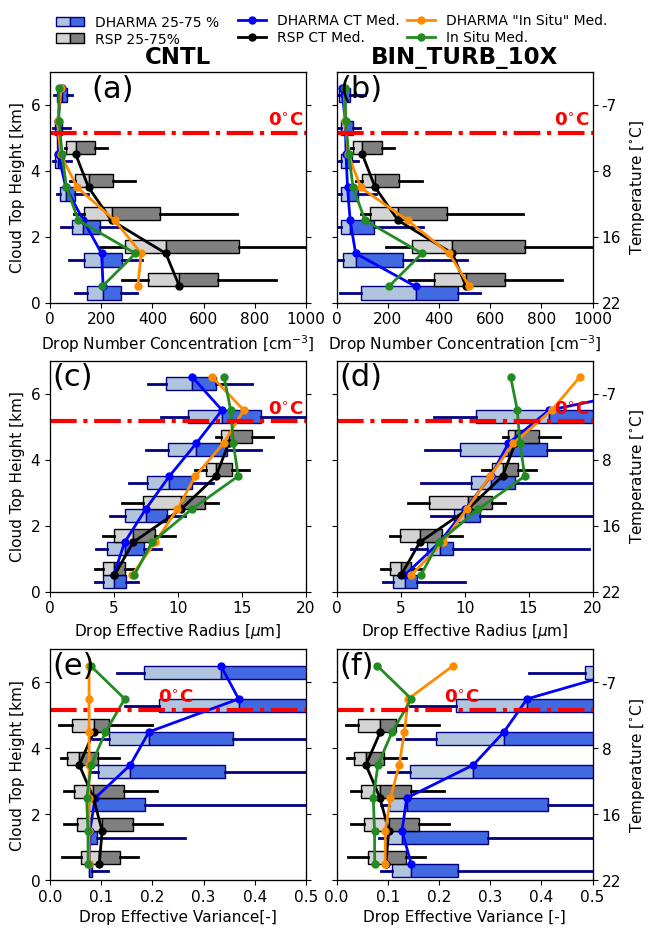

done


In [27]:
fig = plt.figure(figsize=(7,10.5))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)
Fontsize=11
axlist = [ax1,ax2,ax3,ax4,ax5,ax6]
for ax in axlist:
    ax.tick_params(labelsize=Fontsize,which='both')
    ax.set_yticks([0,2,4,6])
ax1.set_ylabel('Cloud Top Height [km]',fontsize=Fontsize)
ax3.set_ylabel('Cloud Top Height [km]',fontsize=Fontsize)
ax5.set_ylabel('Cloud Top Height [km]',fontsize=Fontsize)

    
#=================================
# Number concentration
#=================================
var1 = 'ct_qnl_lt_200um'
#var1 = 'ct_qncloud'
qn_10 = ct_perc_dict[var1]['10']
qn_90 = ct_perc_dict[var1]['90']
qn_25 = ct_perc_dict[var1]['25']
qn_med = ct_perc_dict[var1]['50']
qn_75 = ct_perc_dict[var1]['75']
qn_mean = ct_perc_dict[var1]['mean']

var1 = 'ct_qnl_lt_200um'
bin_qn_10 = bin_ct_perc_dict[var1]['10']
bin_qn_90 = bin_ct_perc_dict[var1]['90']
bin_qn_25 = bin_ct_perc_dict[var1]['25']
bin_qn_med = bin_ct_perc_dict[var1]['50']
bin_qn_75 = bin_ct_perc_dict[var1]['75']
bin_qn_mean = bin_ct_perc_dict[var1]['mean']

var1 = 'nc'
dharma_is_qn_10 = cntl_perc_dict[var1]['10']
dharma_is_qn_90 = cntl_perc_dict[var1]['90']
dharma_is_qn_25 = cntl_perc_dict[var1]['25']
dharma_is_qn_med = cntl_perc_dict[var1]['50']
dharma_is_qn_75 = cntl_perc_dict[var1]['75']
dharma_is_qn_mean = cntl_perc_dict[var1]['mean']

var1 = 'nc'
dharma_is_bin_qn_10 = bin_perc_dict[var1]['10']
dharma_is_bin_qn_90 = bin_perc_dict[var1]['90']
dharma_is_bin_qn_25 = bin_perc_dict[var1]['25']
dharma_is_bin_qn_med = bin_perc_dict[var1]['50']
dharma_is_bin_qn_75 = bin_perc_dict[var1]['75']
dharma_is_bin_qn_mean = bin_perc_dict[var1]['mean']

var1='nd'
rsp_qn_10 = rsp_ct_perc_dict[var1]['10']
rsp_qn_90 = rsp_ct_perc_dict[var1]['90']
rsp_qn_25 = rsp_ct_perc_dict[var1]['25']
rsp_qn_med = rsp_ct_perc_dict[var1]['50']
rsp_qn_75 = rsp_ct_perc_dict[var1]['75']
rsp_qn_mean = rsp_ct_perc_dict[var1]['mean']

var1 = 'conc'
ffssp_qn_10 = ffssp_perc_dict[var1]['10']*1.e-3
ffssp_qn_90 = ffssp_perc_dict[var1]['90']*1.e-3
ffssp_qn_25 = ffssp_perc_dict[var1]['25']*1.e-3
ffssp_qn_med = ffssp_perc_dict[var1]['50']*1.e-3
ffssp_qn_75 = ffssp_perc_dict[var1]['75']*1.e-3
ffssp_qn_mean = ffssp_perc_dict[var1]['mean']*1.e-3

dark_color = 'navy'
mid_color = 'royalblue'
light_color = 'lightsteelblue'

ffssp_dark_color = 'darkgreen'
ffssp_mid_color = 'seagreen'
ffssp_light_color = 'palegreen'
ffssp_color = 'forestgreen'

dharma_is_light_color = 'navajowhite'
dharma_is_mid_color = 'orange'
dharma_is_dark_color = 'peru'

for ii in range(len(height_bins)-1):
    

    #--------------------------
    # Number Concentration
    #--------------------------
    ##############
    # DHARMA
    ##############
    # left box
    xx = qn_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = qn_med[ii]-qn_25[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = qn_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = qn_75[ii]-qn_med[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))

    # Add whiskers
    ax1.plot([qn_75[ii],qn_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax1.plot([qn_10[ii],qn_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    ##############
    # DHARMA Bin
    ##############
    # left box
    xx = bin_qn_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = bin_qn_med[ii]-bin_qn_25[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = bin_qn_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = bin_qn_75[ii]-bin_qn_med[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))

    # Add whiskers
    ax2.plot([bin_qn_75[ii],bin_qn_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax2.plot([bin_qn_10[ii],bin_qn_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    ##############
    # RSP
    ##############
    # left box
    xx = rsp_qn_25[ii]
    yy = height_midbins[ii]
    xxsize = rsp_qn_med[ii]-rsp_qn_25[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    # right box
    xx = rsp_qn_med[ii]
    yy = height_midbins[ii]
    xxsize = rsp_qn_75[ii]-rsp_qn_med[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))    
    # Add whiskers
    ax1.plot([rsp_qn_75[ii],rsp_qn_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax2.plot([rsp_qn_75[ii],rsp_qn_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax1.plot([rsp_qn_10[ii],rsp_qn_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    ax2.plot([rsp_qn_10[ii],rsp_qn_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    

ax1.set_xlim(0,1000)
ax2.set_xlim(0,1000)
ax1.set_xlabel('Drop Number Concentration [cm$^{-3}$]',fontsize=Fontsize)
ax2.set_xlabel('Drop Number Concentration [cm$^{-3}$]',fontsize=Fontsize)
#ax1.plot(qn_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA CT Med.',markersize=5)
ax1.plot(qn_med,height_midbins,lw=2,marker='o',c='blue',label='DHARMA CT Med.',markersize=5)
#ax2.plot(bin_qn_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA CT Med.',markersize=5)
ax2.plot(bin_qn_med,height_midbins,lw=2,marker='o',c='blue',label='DHARMA CT Med.',markersize=5)
ax1.plot(rsp_qn_med,height_midbins,lw=2,marker='o',c='black',label='RSP CT Med.',markersize=5)
ax2.plot(rsp_qn_med,height_midbins,lw=2,marker='o',c='black',label='RSP CT Med.',markersize=5)
ax1.plot(dharma_is_qn_med,height_midbins,lw=2,marker='o',c='darkorange',label='DHARMA "In Situ" Med.',markersize=5)
ax2.plot(dharma_is_bin_qn_med,height_midbins,lw=2,marker='o',c='darkorange',label='DHARMA "In Situ" Med.',markersize=5)
#ax1.plot(ffssp_qn_med,height_midbins,lw=2,marker='o',c=ffssp_dark_color,label='In Situ Med.',markersize=5)
ax1.plot(ffssp_qn_med,height_midbins,lw=2,marker='o',c=ffssp_color,label='In Situ Med.',markersize=5)
#ax2.plot(ffssp_qn_med,height_midbins,lw=2,marker='o',c=ffssp_dark_color,label='In Situ Med.',markersize=5)
ax2.plot(ffssp_qn_med,height_midbins,lw=2,marker='o',c=ffssp_color,label='In Situ Med.',markersize=5)

#=================================
# Effective Radius
#=================================
# ct bulk
var2 = 'ct_reff_l_lt_200um'
reff_c_10 = ct_perc_dict[var2]['10']
reff_c_90 = ct_perc_dict[var2]['90']
reff_c_25 = ct_perc_dict[var2]['25']
reff_c_med = ct_perc_dict[var2]['50']
reff_c_75 = ct_perc_dict[var2]['75']
reff_c_mean = ct_perc_dict[var2]['mean']

# ct bin
var2 = 'ct_reff_l_lt_200um'
bin_reff_c_10 = bin_ct_perc_dict[var2]['10']
bin_reff_c_90 = bin_ct_perc_dict[var2]['90']
bin_reff_c_25 = bin_ct_perc_dict[var2]['25']
bin_reff_c_med = bin_ct_perc_dict[var2]['50']
bin_reff_c_75 = bin_ct_perc_dict[var2]['75']
bin_reff_c_mean = bin_ct_perc_dict[var2]['mean']

# bulk in situ
var2 = 'reff_c'
dharma_is_reff_c_10 = cntl_perc_dict[var2]['10']
dharma_is_reff_c_90 = cntl_perc_dict[var2]['90']
dharma_is_reff_c_25 = cntl_perc_dict[var2]['25']
dharma_is_reff_c_med = cntl_perc_dict[var2]['50']
dharma_is_reff_c_75 = cntl_perc_dict[var2]['75']
dharma_is_reff_c_mean = cntl_perc_dict[var2]['mean']

# bin in isitu
var2 = 'reff_c'
dharma_is_bin_reff_c_10 = bin_perc_dict[var2]['10']
dharma_is_bin_reff_c_90 = bin_perc_dict[var2]['90']
dharma_is_bin_reff_c_25 = bin_perc_dict[var2]['25']
dharma_is_bin_reff_c_med = bin_perc_dict[var2]['50']
dharma_is_bin_reff_c_75 = bin_perc_dict[var2]['75']
dharma_is_bin_reff_c_mean = bin_perc_dict[var2]['mean']

# rsp
var2 = 'Reff'
rsp_reff_c_10 = rsp_ct_perc_dict[var2]['10']
rsp_reff_c_90 = rsp_ct_perc_dict[var2]['90']
rsp_reff_c_25 = rsp_ct_perc_dict[var2]['25']
rsp_reff_c_med = rsp_ct_perc_dict[var2]['50']
rsp_reff_c_75 = rsp_ct_perc_dict[var2]['75']
rsp_reff_c_mean = rsp_ct_perc_dict[var2]['mean']

# ffssp in situ
var2 = 'reff'
ffssp_reff_c_10 = ffssp_perc_dict[var2]['10']
ffssp_reff_c_90 = ffssp_perc_dict[var2]['90']
ffssp_reff_c_25 = ffssp_perc_dict[var2]['25']
ffssp_reff_c_med = ffssp_perc_dict[var2]['50']
ffssp_reff_c_75 = ffssp_perc_dict[var2]['75']
ffssp_reff_c_mean = ffssp_perc_dict[var2]['mean']

for ii in range(len(height_bins)-1):
    
    #--------------------------
    # Effective radius
    #--------------------------

    ##############
    # DHARMA
    ##############
    # left box
    xx = reff_c_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = reff_c_med[ii]-reff_c_25[ii]
    yysize = 0.4
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = reff_c_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = reff_c_75[ii]-reff_c_med[ii]
    yysize = 0.4
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))
    # Add whiskers
    ax3.plot([reff_c_75[ii],reff_c_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax3.plot([reff_c_10[ii],reff_c_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    
    ##############
    # DHARMA Bin
    ##############
    # left box
    xx = bin_reff_c_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = bin_reff_c_med[ii]-bin_reff_c_25[ii]
    yysize = 0.4
    ax4.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = bin_reff_c_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = bin_reff_c_75[ii]-bin_reff_c_med[ii]
    yysize = 0.4
    ax4.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))
    # Add whiskers
    ax4.plot([bin_reff_c_75[ii],bin_reff_c_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax4.plot([bin_reff_c_10[ii],bin_reff_c_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    ##############
    # RSP
    ##############
    # left box
    xx = rsp_reff_c_25[ii]
    yy = height_midbins[ii]
    xxsize = rsp_reff_c_med[ii]-rsp_reff_c_25[ii]
    yysize = 0.4
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    ax4.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    # right box
    xx = rsp_reff_c_med[ii]
    yy = height_midbins[ii]
    xxsize = rsp_reff_c_75[ii]-rsp_reff_c_med[ii]
    yysize = 0.4
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))
    ax4.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))    
    
    # Add whiskers
    ax3.plot([rsp_reff_c_75[ii],rsp_reff_c_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax4.plot([rsp_reff_c_75[ii],rsp_reff_c_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax3.plot([rsp_reff_c_10[ii],rsp_reff_c_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    ax4.plot([rsp_reff_c_10[ii],rsp_reff_c_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    

ax3.set_xlim(0,20)
ax4.set_xlim(0,20)
ax3.set_xlabel('Drop Effective Radius [$\\mu$m]',fontsize=Fontsize)
ax4.set_xlabel('Drop Effective Radius [$\\mu$m]',fontsize=Fontsize)
#ax3.plot(reff_c_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA CT Med.',markersize=5)
ax3.plot(reff_c_med,height_midbins,lw=2,marker='o',c='blue',markersize=5)
#ax4.plot(bin_reff_c_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA CT Med.',markersize=5)
ax4.plot(bin_reff_c_med,height_midbins,lw=2,marker='o',c='blue',label='DHARMA CT Med.',markersize=5)
ax3.plot(rsp_reff_c_med,height_midbins,lw=2,marker='o',c='black',markersize=5)
ax4.plot(rsp_reff_c_med,height_midbins,lw=2,marker='o',c='black',label='RSP CT Med.',markersize=5)
ax3.plot(dharma_is_reff_c_med,height_midbins,lw=2,marker='o',c='darkorange',markersize=5)
ax4.plot(dharma_is_bin_reff_c_med,height_midbins,lw=2,marker='o',c='darkorange',label='DHARMA "In Situ" Med.',markersize=5)
#ax3.plot(ffssp_reff_c_med,height_midbins,lw=2,marker='o',c=ffssp_dark_color,label='In Situ Med.',markersize=5)
ax3.plot(ffssp_reff_c_med,height_midbins,lw=2,marker='o',c=ffssp_color,markersize=5)
#ax4.plot(ffssp_reff_c_med,height_midbins,lw=2,marker='o',c=ffssp_dark_color,label='In Situ Med.',markersize=5)
ax4.plot(ffssp_reff_c_med,height_midbins,lw=2,marker='o',c=ffssp_color,label='In Situ Med.',markersize=5)




#=================================
# Effective Variance
#=================================
# rsp
var3 = 've'
rsp_veff_c_10 = rsp_ct_perc_dict[var3]['10']
rsp_veff_c_90 = rsp_ct_perc_dict[var3]['90']
rsp_veff_c_25 = rsp_ct_perc_dict[var3]['25']
rsp_veff_c_med = rsp_ct_perc_dict[var3]['50']
rsp_veff_c_75 = rsp_ct_perc_dict[var3]['75']
rsp_veff_c_mean = rsp_ct_perc_dict[var3]['mean']

# ct bulk
var3 = 'ct_veff_l_lt_200um'
#var3 = 'ct_veff_c_int'
veff_c_10 = ct_perc_dict[var3]['10']
veff_c_90 = ct_perc_dict[var3]['90']
veff_c_25 = ct_perc_dict[var3]['25']
veff_c_med = ct_perc_dict[var3]['50']
veff_c_75 = ct_perc_dict[var3]['75']
veff_c_mean = ct_perc_dict[var3]['mean']

# ct bin
var3 = 'ct_veff_l_lt_200um'
bin_veff_c_10 = bin_ct_perc_dict[var3]['10']
bin_veff_c_90 = bin_ct_perc_dict[var3]['90']
bin_veff_c_25 = bin_ct_perc_dict[var3]['25']
bin_veff_c_med = bin_ct_perc_dict[var3]['50']
bin_veff_c_75 = bin_ct_perc_dict[var3]['75']
bin_veff_c_mean = bin_ct_perc_dict[var3]['mean']

# in situ bulk
var3 = 'veff_c_int'
dharma_is_veff_c_10 = cntl_perc_dict[var3]['10']
dharma_is_veff_c_90 = cntl_perc_dict[var3]['90']
dharma_is_veff_c_25 = cntl_perc_dict[var3]['25']
dharma_is_veff_c_med = cntl_perc_dict[var3]['50']
dharma_is_veff_c_75 = cntl_perc_dict[var3]['75']
dharma_is_veff_c_mean = cntl_perc_dict[var3]['mean']

# in situ bin
var3 = 'veff_c'
dharma_is_bin_veff_c_10 = bin_perc_dict[var3]['10']
dharma_is_bin_veff_c_90 = bin_perc_dict[var3]['90']
dharma_is_bin_veff_c_25 = bin_perc_dict[var3]['25']
dharma_is_bin_veff_c_med = bin_perc_dict[var3]['50']
dharma_is_bin_veff_c_75 = bin_perc_dict[var3]['75']
dharma_is_bin_veff_c_mean = bin_perc_dict[var3]['mean']

# ffssp in situ
var3 = 'veff'
ffssp_veff_c_10 = ffssp_perc_dict[var3]['10']
ffssp_veff_c_90 = ffssp_perc_dict[var3]['90']
ffssp_veff_c_25 = ffssp_perc_dict[var3]['25']
ffssp_veff_c_med = ffssp_perc_dict[var3]['50']
ffssp_veff_c_75 = ffssp_perc_dict[var3]['75']
ffssp_veff_c_mean = ffssp_perc_dict[var3]['mean']

for ii in range(len(height_bins)-1):
    
    ##############
    # DHARMA
    ##############
    # left box
    xx = veff_c_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = veff_c_med[ii]-veff_c_25[ii]
    yysize = 0.4
    ax5.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = veff_c_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = veff_c_75[ii]-veff_c_med[ii]
    yysize = 0.4
    ax5.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))
    # Add whiskers
    ax5.plot([veff_c_75[ii],veff_c_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax5.plot([veff_c_10[ii],veff_c_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    

    ##############
    # DHARMA Bin
    ##############
    # left box
    xx = bin_veff_c_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = bin_veff_c_med[ii]-bin_veff_c_25[ii]
    yysize = 0.4
    ax6.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = bin_veff_c_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = bin_veff_c_75[ii]-bin_veff_c_med[ii]
    yysize = 0.4
    ax6.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))
    # Add whiskers
    ax6.plot([bin_veff_c_75[ii],bin_veff_c_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax6.plot([bin_veff_c_10[ii],bin_veff_c_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    ##############
    # RSP
    ##############
    # left box
    xx = rsp_veff_c_25[ii]
    yy = height_midbins[ii]
    xxsize = rsp_veff_c_med[ii]-rsp_veff_c_25[ii]
    yysize = 0.4
    ax5.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    ax6.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    # right box
    xx = rsp_veff_c_med[ii]
    yy = height_midbins[ii]
    xxsize = rsp_veff_c_75[ii]-rsp_veff_c_med[ii]
    yysize = 0.4
    ax5.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))
    ax6.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))    
    
    # Add whiskers
    ax5.plot([rsp_veff_c_75[ii],rsp_veff_c_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax6.plot([rsp_veff_c_75[ii],rsp_veff_c_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax5.plot([rsp_veff_c_10[ii],rsp_veff_c_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    ax6.plot([rsp_veff_c_10[ii],rsp_veff_c_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')        


ax5.set_xlabel('Drop Effective Variance[-]',fontsize=Fontsize)
ax6.set_xlabel('Drop Effective Variance [-]',fontsize=Fontsize)
#ax5.plot(veff_c_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA CT Med.',markersize=5)
ax5.plot(veff_c_med,height_midbins,lw=2,marker='o',c='blue',label='DHARMA CT Med.',markersize=5)
#ax6.plot(bin_veff_c_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA CT Med.',markersize=5)
ax6.plot(bin_veff_c_med,height_midbins,lw=2,marker='o',c='blue',label='DHARMA CT Med.',markersize=5)
ax5.plot(rsp_veff_c_med,height_midbins,lw=2,marker='o',c='black',label='RSP CT Med.',markersize=5)
ax6.plot(rsp_veff_c_med,height_midbins,lw=2,marker='o',c='black',label='RSP CT Med.',markersize=5)
ax5.plot(dharma_is_veff_c_med,height_midbins,lw=2,marker='o',c='darkorange',label='DHARMA "In Situ" Med.',markersize=5)
ax6.plot(dharma_is_bin_veff_c_med,height_midbins,lw=2,marker='o',c='darkorange',label='DHARMA "In Situ" Med.',markersize=5)
#ax5.plot(ffssp_veff_c_med,height_midbins,lw=2,marker='o',c=ffssp_dark_color,label='In Situ Med.',markersize=5)
ax5.plot(ffssp_veff_c_med,height_midbins,lw=2,marker='o',c=ffssp_color,label='In Situ Med.',markersize=5)
#ax6.plot(ffssp_veff_c_med,height_midbins,lw=2,marker='o',c=ffssp_dark_color,label='In Situ Med.',markersize=5)
ax6.plot(ffssp_veff_c_med,height_midbins,lw=2,marker='o',c=ffssp_color,label='In Situ Med.',markersize=5)
ax5.set_xlim(0,0.5)
ax6.set_xlim(0,0.5)
#dum_ticks = np.arange(0.,0.6,0.1)
#dum_tick_labels = ['0','0.05','0.1','0.15','0.2','0.25']
#dum_tick_labels = ['0','0.1','0.2','0.3','0.4','0.5']
#ax5.set_xticks(dum_ticks)
#ax6.set_xticks(dum_ticks)
#ax5.set_xticklabels(dum_tick_labels)
#ax6.set_xticklabels(dum_tick_labels)
    
for ax in axlist:
    ax.set_ylim(height_bins[0],height_bins[-1])
    
# Plot CTT on first subplot
ax1a = ax1.twinx()
ax2a = ax2.twinx()
ax1b = ax1.twiny()
ax2b = ax2.twiny()
ax2a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax1a.yaxis.labelpad = 5
ax2a.yaxis.labelpad = 5
ax1b.plot(rsp_qn_mean_interp,height_bins,marker='D',alpha=0.)
ax2b.plot(rsp_qn_mean_interp,height_bins,marker='D',alpha=0.)
ax1b.set_xticks([])
ax2b.set_xticks([])
dum_yticks = ax1.get_yticks()
ax1a.set_yticks(dum_yticks)
ax2a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
#ax1a.set_yticklabels(dum_yticks2)
ax1a.set_yticklabels([])
ax2a.set_yticklabels(dum_yticks2)
ax1a.tick_params(labelsize=Fontsize,which='both',pad=3)
ax2a.tick_params(labelsize=Fontsize,which='both',pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax1.tick_params(axis='x',pad=3)
ax2.tick_params(axis='x',pad=3)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax1a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax2a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax1a.set_ylim(height_bins[0],height_bins[-1])
ax2a.set_ylim(height_bins[0],height_bins[-1])
ax2.set_yticklabels([])

# Plot CTT on second subplot
ax3a = ax3.twinx()
ax4a = ax4.twinx()
ax3b = ax3.twiny()
ax4b = ax4.twiny()
ax4a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax3a.yaxis.labelpad = 5
ax4a.yaxis.labelpad = 5
ax3b.plot(rsp_reff_l_mean_interp,height_bins,marker='D',alpha=0.)
ax4b.plot(rsp_reff_l_mean_interp,height_bins,marker='D',alpha=0.)
ax3b.set_xticks([])
ax4b.set_xticks([])
dum_yticks = ax3.get_yticks()
ax4a.set_yticks(dum_yticks)
ax3a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
#ax3a.set_yticklabels(dum_yticks2)
ax3a.set_yticklabels([])
ax4a.set_yticklabels(dum_yticks2)
ax3a.tick_params(labelsize=Fontsize,which='both',pad=3)
ax4a.tick_params(labelsize=Fontsize,which='both',pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax3.tick_params(axis='x',pad=3)
ax4.tick_params(axis='x',pad=3)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax3a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax4a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax3a.set_ylim(height_bins[0],height_bins[-1])
ax4a.set_ylim(height_bins[0],height_bins[-1])
ax4.set_yticklabels([])
    
# Plot CTT on third subplot
ax5a = ax5.twinx()
ax6a = ax6.twinx()
ax5b = ax5.twiny()
ax6b = ax6.twiny()
ax6a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax5a.yaxis.labelpad = 5
ax6a.yaxis.labelpad = 5
ax5b.plot(rsp_ve_mean_interp,height_bins,marker='D',alpha=0.)
ax6b.plot(rsp_ve_mean_interp,height_bins,marker='D',alpha=0.)
ax5b.set_xticks([])
ax6b.set_xticks([])
dum_yticks = ax5.get_yticks()
ax6a.set_yticks(dum_yticks)
ax5a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
#ax3a.set_yticklabels(dum_yticks2)
ax5a.set_yticklabels([])
ax6a.set_yticklabels(dum_yticks2)
ax5a.tick_params(labelsize=Fontsize,which='both',pad=3)
ax6a.tick_params(labelsize=Fontsize,which='both',pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax5.tick_params(axis='x',pad=3)
ax6.tick_params(axis='x',pad=3)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax5a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax6a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax5a.set_ylim(height_bins[0],height_bins[-1])
ax6a.set_ylim(height_bins[0],height_bins[-1])
ax6.set_yticklabels([])    
    
    
dumx=0.01
dumy=0.99
ax1.text(dumx+0.15,dumy,'(a)',transform=ax1.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax2.text(dumx,dumy,'(b)',transform=ax2.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax3.text(dumx,dumy,'(c)',transform=ax3.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax4.text(dumx,dumy,'(d)',transform=ax4.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax5.text(dumx,dumy,'(e)',transform=ax5.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax6.text(dumx,dumy,'(f)',transform=ax6.transAxes,fontsize=Fontsize*2.,va='top',ha='left')

ax1.text(850,zero_height+0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold')
ax2.text(850,zero_height+0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold',zorder=100)
ax3.text(17,zero_height+0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold')
ax4.text(17,zero_height+0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold')
ax5.text(0.21,zero_height+0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold')
ax6.text(0.21,zero_height+0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold')


#lgnd1 = ax2.legend(framealpha=True,loc='upper right',bbox_to_anchor=(1.02,1.02),labelspacing=0.2,borderpad=0.3,facecolor='snow')
lgnd1 = ax2.legend(framealpha=False,loc='upper right',bbox_to_anchor=(1.1,1.3),labelspacing=0.2,borderpad=0.3,ncol=2,columnspacing=0.5)

colors1 = ['lightgrey','grey']
edgecolor1 = 'black'
colors2 = [light_color,mid_color]
edgecolor2 = dark_color

patch1 = MulticolorPatch(colors1,edgecolor1)
patch2 = MulticolorPatch(colors2,edgecolor2)
h = [patch2,patch1]
l = ['DHARMA 25-75 %','RSP 25-75%']

lgnd2 = ax1.legend(h, l, loc='upper right', 
         handler_map={MulticolorPatch: MulticolorPatchHandler()}, 
         #bbox_to_anchor=(1.02,1.02),framealpha=True,labelspacing=0.2,borderpad=0.25,facecolor='snow')
         #bbox_to_anchor=(1.02,1.02),framealpha=False,labelspacing=0.2,borderpad=0.25)
         bbox_to_anchor=(0.7,1.29),framealpha=False,labelspacing=0.2,borderpad=0.25)

ax1.set_title('CNTL',fontsize=Fontsize*1.5,fontweight='bold')
ax2.set_title('BIN_TURB_10X',fontsize=Fontsize*1.5,fontweight='bold')

if False:
    alpha=0.5
    dum_color = 'limegreen'
    ax1.scatter(ffssp_dict['conc']*1.e-3,ffssp_dict['alt'],c=dum_color,s=5,alpha=alpha,label='In Situ 1-Hz')
    ax2.scatter(ffssp_dict['conc']*1.e-3,ffssp_dict['alt'],c=dum_color,s=5,alpha=alpha,label='In Situ 1-Hz')
    ax3.scatter(ffssp_dict['reff'],ffssp_dict['alt'],c=dum_color,s=5,alpha=alpha,label='In Situ 1-Hz')
    ax4.scatter(ffssp_dict['reff'],ffssp_dict['alt'],c=dum_color,s=5,alpha=alpha,label='In Situ 1-Hz')
    ax5.scatter(ffssp_dict['veff'],ffssp_dict['alt'],c=dum_color,s=5,alpha=alpha,label='In Situ 1-Hz')
    ax6.scatter(ffssp_dict['veff'],ffssp_dict['alt'],c=dum_color,s=5,alpha=alpha,label='In Situ 1-Hz')
    
    # Create custom legend elements
    h2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=dum_color, markersize=5)]
    l2 = ['In Situ 1-Hz']
    lgnd3 = ax3.legend(h2,l2,framealpha=False,loc='upper left',bbox_to_anchor=(0.7,2.4),labelspacing=0.2,borderpad=0.3)


plt.subplots_adjust(hspace=0.25,wspace=0.12)

#fig_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
#outfile = 'cntl_bin_turb_10x_rsp_ffssp_profiles.png'
#plt.savefig(fig_path+outfile,dpi=300,bbox_inches='tight')

#save_path = '/discover/nobackup/mwstanfo/figures/micro2macro_poster/'
save_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
outfile = 'fig_cntl_bin_turb_10x_rsp_ffssp_profiles_alternative_with_Veff.png'
#plt.savefig(save_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()  
print('done')

# Optional version of Fig. 7 that plots simulations, RSP, and FFSSP all as box and whisker percentile plots

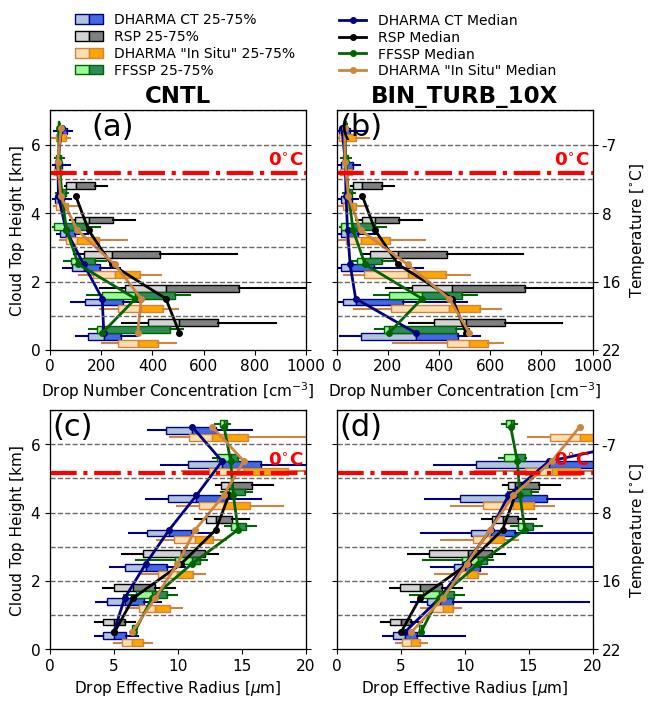

In [28]:
fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
Fontsize=11
axlist = [ax1,ax2,ax3,ax4]
for ax in axlist:
    ax.tick_params(labelsize=Fontsize,which='both')
    ax.set_yticks([0,2,4,6])
ax1.set_ylabel('Cloud Top Height [km]',fontsize=Fontsize)
ax3.set_ylabel('Cloud Top Height [km]',fontsize=Fontsize)

    
#=================================
# Number concentration
#=================================
#var1 = 'ct_qnl_lt_200um'
var1 = 'ct_qncloud'
qn_10 = ct_perc_dict[var1]['10']
qn_90 = ct_perc_dict[var1]['90']
qn_25 = ct_perc_dict[var1]['25']
qn_med = ct_perc_dict[var1]['50']
qn_75 = ct_perc_dict[var1]['75']
qn_mean = ct_perc_dict[var1]['mean']

var1 = 'nc'
dharma_is_qn_10 = cntl_perc_dict[var1]['10']
dharma_is_qn_90 = cntl_perc_dict[var1]['90']
dharma_is_qn_25 = cntl_perc_dict[var1]['25']
dharma_is_qn_med = cntl_perc_dict[var1]['50']
dharma_is_qn_75 = cntl_perc_dict[var1]['75']
dharma_is_qn_mean = cntl_perc_dict[var1]['mean']

var1 = 'ct_qnl_lt_200um'
bin_qn_10 = bin_ct_perc_dict[var1]['10']
bin_qn_90 = bin_ct_perc_dict[var1]['90']
bin_qn_25 = bin_ct_perc_dict[var1]['25']
bin_qn_med = bin_ct_perc_dict[var1]['50']
bin_qn_75 = bin_ct_perc_dict[var1]['75']
bin_qn_mean = bin_ct_perc_dict[var1]['mean']

var1 = 'nc'
dharma_is_bin_qn_10 = bin_perc_dict[var1]['10']
dharma_is_bin_qn_90 = bin_perc_dict[var1]['90']
dharma_is_bin_qn_25 = bin_perc_dict[var1]['25']
dharma_is_bin_qn_med = bin_perc_dict[var1]['50']
dharma_is_bin_qn_75 = bin_perc_dict[var1]['75']
dharma_is_bin_qn_mean = bin_perc_dict[var1]['mean']

var1='nd'
rsp_qn_10 = rsp_ct_perc_dict[var1]['10']
rsp_qn_90 = rsp_ct_perc_dict[var1]['90']
rsp_qn_25 = rsp_ct_perc_dict[var1]['25']
rsp_qn_med = rsp_ct_perc_dict[var1]['50']
rsp_qn_75 = rsp_ct_perc_dict[var1]['75']
rsp_qn_mean = rsp_ct_perc_dict[var1]['mean']

var1 = 'conc'
ffssp_qn_10 = ffssp_perc_dict[var1]['10']*1.e-3
ffssp_qn_90 = ffssp_perc_dict[var1]['90']*1.e-3
ffssp_qn_25 = ffssp_perc_dict[var1]['25']*1.e-3
ffssp_qn_med = ffssp_perc_dict[var1]['50']*1.e-3
ffssp_qn_75 = ffssp_perc_dict[var1]['75']*1.e-3
ffssp_qn_mean = ffssp_perc_dict[var1]['mean']*1.e-3


dark_color = 'navy'
mid_color = 'royalblue'
light_color = 'lightsteelblue'

ffssp_dark_color = 'darkgreen'
ffssp_mid_color = 'seagreen'
ffssp_light_color = 'palegreen'

dharma_is_light_color = 'navajowhite'
dharma_is_mid_color = 'orange'
dharma_is_dark_color = 'peru'

whisker_lw=1.5


for ii in range(len(height_bins)-1):
    

    #--------------------------
    # Number Concentration
    #--------------------------
    ##############
    # DHARMA
    ##############
    # left box
    xx = qn_25[ii]
    yy = height_midbins[ii]-0.2
    xxsize = qn_med[ii]-qn_25[ii]
    yysize = 0.2
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = qn_med[ii]
    yy = height_midbins[ii]-0.2
    xxsize = qn_75[ii]-qn_med[ii]
    yysize = 0.2
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))

    # Add whiskers
    ax1.plot([qn_75[ii],qn_90[ii]],[height_midbins[ii]-0.1,height_midbins[ii]-0.1],lw=whisker_lw,c=dark_color)
    ax1.plot([qn_10[ii],qn_25[ii]],[height_midbins[ii]-0.1,height_midbins[ii]-0.1],lw=whisker_lw,c=dark_color)

    ##############
    # DHARMA In Situ
    ##############
    # left box
    xx = dharma_is_qn_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = dharma_is_qn_med[ii]-dharma_is_qn_25[ii]
    yysize = 0.2
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dharma_is_dark_color,\
                           facecolor=dharma_is_light_color))
    # right box
    xx = dharma_is_qn_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = dharma_is_qn_75[ii]-dharma_is_qn_med[ii]
    yysize = 0.2
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dharma_is_dark_color,\
                           facecolor=dharma_is_mid_color))

    # Add whiskers
    ax1.plot([dharma_is_qn_75[ii],dharma_is_qn_90[ii]],[height_midbins[ii]-0.3,height_midbins[ii]-0.3],lw=whisker_lw,c=dharma_is_dark_color)
    ax1.plot([dharma_is_qn_10[ii],dharma_is_qn_25[ii]],[height_midbins[ii]-0.3,height_midbins[ii]-0.3],lw=whisker_lw,c=dharma_is_dark_color)
    
    ##############
    # DHARMA Bin
    ##############
    # left box
    xx = bin_qn_25[ii]
    yy = height_midbins[ii]-0.2
    xxsize = bin_qn_med[ii]-bin_qn_25[ii]
    yysize = 0.2
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = bin_qn_med[ii]
    yy = height_midbins[ii]-0.2
    xxsize = bin_qn_75[ii]-bin_qn_med[ii]
    yysize = 0.2
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))

    # Add whiskers
    ax2.plot([bin_qn_75[ii],bin_qn_90[ii]],[height_midbins[ii]-0.1,height_midbins[ii]-0.1],lw=whisker_lw,c=dark_color)
    ax2.plot([bin_qn_10[ii],bin_qn_25[ii]],[height_midbins[ii]-0.1,height_midbins[ii]-0.1],lw=whisker_lw,c=dark_color)
    
    
    ##############
    # DHARMA Bin In Situ
    ##############
    # left box
    xx = dharma_is_bin_qn_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = dharma_is_bin_qn_med[ii]-dharma_is_bin_qn_25[ii]
    yysize = 0.2
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dharma_is_dark_color,\
                           facecolor=dharma_is_light_color))
    # right box
    xx = dharma_is_bin_qn_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = dharma_is_bin_qn_75[ii]-dharma_is_bin_qn_med[ii]
    yysize = 0.2
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dharma_is_dark_color,\
                           facecolor=dharma_is_mid_color))

    # Add whiskers
    ax2.plot([dharma_is_bin_qn_75[ii],dharma_is_bin_qn_90[ii]],[height_midbins[ii]-0.3,height_midbins[ii]-0.3],lw=whisker_lw,c=dharma_is_dark_color)
    ax2.plot([dharma_is_bin_qn_10[ii],dharma_is_bin_qn_25[ii]],[height_midbins[ii]-0.3,height_midbins[ii]-0.3],lw=whisker_lw,c=dharma_is_dark_color)
    
    ##############
    # RSP
    ##############
    # left box
    xx = rsp_qn_25[ii]
    yy = height_midbins[ii]+0.2
    xxsize = rsp_qn_med[ii]-rsp_qn_25[ii]
    yysize = 0.2
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    # right box
    xx = rsp_qn_med[ii]
    yy = height_midbins[ii]+0.2
    xxsize = rsp_qn_75[ii]-rsp_qn_med[ii]
    yysize = 0.2
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))    
    # Add whiskers
    ax1.plot([rsp_qn_75[ii],rsp_qn_90[ii]],[height_midbins[ii]+0.3,height_midbins[ii]+0.3],lw=whisker_lw,c='black')
    ax2.plot([rsp_qn_75[ii],rsp_qn_90[ii]],[height_midbins[ii]+0.3,height_midbins[ii]+0.3],lw=whisker_lw,c='black')
    ax1.plot([rsp_qn_10[ii],rsp_qn_25[ii]],[height_midbins[ii]+0.3,height_midbins[ii]+0.3],lw=whisker_lw,c='black')    
    ax2.plot([rsp_qn_10[ii],rsp_qn_25[ii]],[height_midbins[ii]+0.3,height_midbins[ii]+0.3],lw=whisker_lw,c='black')   
    
    ##############
    # Learjet
    ##############
    # left box
    xx = ffssp_qn_25[ii]
    yy = height_midbins[ii]
    xxsize = ffssp_qn_med[ii]-ffssp_qn_25[ii]
    yysize = 0.2
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=ffssp_dark_color,\
                           facecolor=ffssp_light_color))
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=ffssp_dark_color,\
                           facecolor=ffssp_light_color))
    # right box
    xx = ffssp_qn_med[ii]
    yy = height_midbins[ii]
    xxsize = ffssp_qn_75[ii]-ffssp_qn_med[ii]
    yysize = 0.2
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=ffssp_dark_color,\
                           facecolor=ffssp_mid_color))
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=ffssp_dark_color,\
                           facecolor=ffssp_mid_color))

    # Add whiskers
    ax1.plot([ffssp_qn_75[ii],ffssp_qn_90[ii]],[height_midbins[ii]+0.1,height_midbins[ii]+0.1],lw=whisker_lw,c=ffssp_dark_color)
    ax2.plot([ffssp_qn_75[ii],ffssp_qn_90[ii]],[height_midbins[ii]+0.1,height_midbins[ii]+0.1],lw=whisker_lw,c=ffssp_dark_color)
    ax1.plot([ffssp_qn_10[ii],ffssp_qn_25[ii]],[height_midbins[ii]+0.1,height_midbins[ii]+0.1],lw=whisker_lw,c=ffssp_dark_color)
    ax2.plot([ffssp_qn_10[ii],ffssp_qn_25[ii]],[height_midbins[ii]+0.1,height_midbins[ii]+0.1],lw=whisker_lw,c=ffssp_dark_color)
    

ax1.set_xlim(0,1000)
ax2.set_xlim(0,1000)
tmp_markersize=4
ax1.set_xlabel('Drop Number Concentration [cm$^{-3}$]',fontsize=Fontsize)
ax2.set_xlabel('Drop Number Concentration [cm$^{-3}$]',fontsize=Fontsize)
ax1.plot(qn_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA CT Median',markersize=tmp_markersize)
ax2.plot(bin_qn_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA CT Median',markersize=tmp_markersize)
ax1.plot(rsp_qn_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=tmp_markersize)
ax2.plot(rsp_qn_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=tmp_markersize)
ax1.plot(ffssp_qn_med,height_midbins,lw=2,marker='o',c=ffssp_dark_color,label='FFSSP Median',markersize=tmp_markersize)
ax2.plot(ffssp_qn_med,height_midbins,lw=2,marker='o',c=ffssp_dark_color,label='FFSSP Median',markersize=tmp_markersize)
ax1.plot(dharma_is_qn_med,height_midbins,lw=2,marker='o',c=dharma_is_dark_color,label='DHARMA "In Situ" Median',markersize=tmp_markersize)
ax2.plot(dharma_is_bin_qn_med,height_midbins,lw=2,marker='o',c=dharma_is_dark_color,label='DHARMA "In Situ" Median',markersize=tmp_markersize)

#=================================
# Effective Radius
#=================================
#var2 = 'reff'
var2 = 'ct_reff_l_lt_200um'
reff_c_10 = ct_perc_dict[var2]['10']
reff_c_90 = ct_perc_dict[var2]['90']
reff_c_25 = ct_perc_dict[var2]['25']
reff_c_med = ct_perc_dict[var2]['50']
reff_c_75 = ct_perc_dict[var2]['75']
reff_c_mean = ct_perc_dict[var2]['mean']

var2 = 'reff_c'
dharma_is_reff_c_10 = cntl_perc_dict[var2]['10']
dharma_is_reff_c_90 = cntl_perc_dict[var2]['90']
dharma_is_reff_c_25 = cntl_perc_dict[var2]['25']
dharma_is_reff_c_med = cntl_perc_dict[var2]['50']
dharma_is_reff_c_75 = cntl_perc_dict[var2]['75']
dharma_is_reff_c_mean = cntl_perc_dict[var2]['mean']

var2 = 'ct_reff_l_lt_200um'
bin_reff_c_10 = bin_ct_perc_dict[var2]['10']
bin_reff_c_90 = bin_ct_perc_dict[var2]['90']
bin_reff_c_25 = bin_ct_perc_dict[var2]['25']
bin_reff_c_med = bin_ct_perc_dict[var2]['50']
bin_reff_c_75 = bin_ct_perc_dict[var2]['75']
bin_reff_c_mean = bin_ct_perc_dict[var2]['mean']

var2 = 'reff_c'
dharma_is_bin_reff_c_10 = bin_perc_dict[var2]['10']
dharma_is_bin_reff_c_90 = bin_perc_dict[var2]['90']
dharma_is_bin_reff_c_25 = bin_perc_dict[var2]['25']
dharma_is_bin_reff_c_med = bin_perc_dict[var2]['50']
dharma_is_bin_reff_c_75 = bin_perc_dict[var2]['75']
dharma_is_bin_reff_c_mean = bin_perc_dict[var2]['mean']

var2 = 'Reff'
rsp_reff_c_10 = rsp_ct_perc_dict[var2]['10']
rsp_reff_c_90 = rsp_ct_perc_dict[var2]['90']
rsp_reff_c_25 = rsp_ct_perc_dict[var2]['25']
rsp_reff_c_med = rsp_ct_perc_dict[var2]['50']
rsp_reff_c_75 = rsp_ct_perc_dict[var2]['75']
rsp_reff_c_mean = rsp_ct_perc_dict[var2]['mean']

var2 = 'reff'
ffssp_reff_c_10 = ffssp_perc_dict[var2]['10']
ffssp_reff_c_90 = ffssp_perc_dict[var2]['90']
ffssp_reff_c_25 = ffssp_perc_dict[var2]['25']
ffssp_reff_c_med = ffssp_perc_dict[var2]['50']
ffssp_reff_c_75 = ffssp_perc_dict[var2]['75']
ffssp_reff_c_mean = ffssp_perc_dict[var2]['mean']

for ii in range(len(height_bins)-1):
    
    #--------------------------
    # Effective radius
    #--------------------------

    ##############
    # DHARMA
    ##############
    # left box
    xx = reff_c_25[ii]
    yy = height_midbins[ii]-0.2
    xxsize = reff_c_med[ii]-reff_c_25[ii]
    yysize = 0.2
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = reff_c_med[ii]
    yy = height_midbins[ii]-0.2
    xxsize = reff_c_75[ii]-reff_c_med[ii]
    yysize = 0.2
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))
    # Add whiskers
    ax3.plot([reff_c_75[ii],reff_c_90[ii]],[height_midbins[ii]-0.1,height_midbins[ii]-0.1],lw=whisker_lw,c=dark_color)
    ax3.plot([reff_c_10[ii],reff_c_25[ii]],[height_midbins[ii]-0.1,height_midbins[ii]-0.1],lw=whisker_lw,c=dark_color)

    ##############
    # DHARMA In Situ
    ##############
    # left box
    xx = dharma_is_reff_c_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = dharma_is_reff_c_med[ii]-dharma_is_reff_c_25[ii]
    yysize = 0.2
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dharma_is_dark_color,\
                           facecolor=dharma_is_light_color))
    # right box
    xx = dharma_is_reff_c_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = dharma_is_reff_c_75[ii]-dharma_is_reff_c_med[ii]
    yysize = 0.2
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dharma_is_dark_color,\
                           facecolor=dharma_is_mid_color))
    # Add whiskers
    ax3.plot([dharma_is_reff_c_75[ii],dharma_is_reff_c_90[ii]],[height_midbins[ii]-0.3,height_midbins[ii]-0.3],lw=whisker_lw,c=dharma_is_dark_color)
    ax3.plot([dharma_is_reff_c_10[ii],dharma_is_reff_c_25[ii]],[height_midbins[ii]-0.3,height_midbins[ii]-0.3],lw=whisker_lw,c=dharma_is_dark_color)
    
    
    ##############
    # DHARMA Bin
    ##############
    # left box
    xx = bin_reff_c_25[ii]
    yy = height_midbins[ii]-0.2
    xxsize = bin_reff_c_med[ii]-bin_reff_c_25[ii]
    yysize = 0.2
    ax4.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = bin_reff_c_med[ii]
    yy = height_midbins[ii]-0.2
    xxsize = bin_reff_c_75[ii]-bin_reff_c_med[ii]
    yysize = 0.2
    ax4.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))
    # Add whiskers
    ax4.plot([bin_reff_c_75[ii],bin_reff_c_90[ii]],[height_midbins[ii]-0.1,height_midbins[ii]-0.1],lw=whisker_lw,c=dark_color)
    ax4.plot([bin_reff_c_10[ii],bin_reff_c_25[ii]],[height_midbins[ii]-0.1,height_midbins[ii]-0.1],lw=whisker_lw,c=dark_color)
    
    
    ##############
    # DHARMA BIN In Situ
    ##############
    # left box
    xx = dharma_is_bin_reff_c_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = dharma_is_bin_reff_c_med[ii]-dharma_is_bin_reff_c_25[ii]
    yysize = 0.2
    ax4.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dharma_is_dark_color,\
                           facecolor=dharma_is_light_color))
    # right box
    xx = dharma_is_bin_reff_c_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = dharma_is_bin_reff_c_75[ii]-dharma_is_bin_reff_c_med[ii]
    yysize = 0.2
    ax4.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dharma_is_dark_color,\
                           facecolor=dharma_is_mid_color))
    # Add whiskers
    ax4.plot([dharma_is_bin_reff_c_75[ii],dharma_is_bin_reff_c_90[ii]],[height_midbins[ii]-0.3,height_midbins[ii]-0.3],lw=whisker_lw,c=dharma_is_dark_color)
    ax4.plot([dharma_is_bin_reff_c_10[ii],dharma_is_bin_reff_c_25[ii]],[height_midbins[ii]-0.3,height_midbins[ii]-0.3],lw=whisker_lw,c=dharma_is_dark_color)
    
    ##############
    # RSP
    ##############
    # left box
    xx = rsp_reff_c_25[ii]
    yy = height_midbins[ii]+0.2
    xxsize = rsp_reff_c_med[ii]-rsp_reff_c_25[ii]
    yysize = 0.2
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    ax4.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    # right box
    xx = rsp_reff_c_med[ii]
    yy = height_midbins[ii]+0.2
    xxsize = rsp_reff_c_75[ii]-rsp_reff_c_med[ii]
    yysize = 0.2
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))
    ax4.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))  
    
    # Add whiskers
    ax3.plot([rsp_reff_c_75[ii],rsp_reff_c_90[ii]],[height_midbins[ii]+0.3,height_midbins[ii]+0.3],lw=whisker_lw,c='black')
    ax4.plot([rsp_reff_c_75[ii],rsp_reff_c_90[ii]],[height_midbins[ii]+0.3,height_midbins[ii]+0.3],lw=whisker_lw,c='black')
    ax3.plot([rsp_reff_c_10[ii],rsp_reff_c_25[ii]],[height_midbins[ii]+0.3,height_midbins[ii]+0.3],lw=whisker_lw,c='black')    
    ax4.plot([rsp_reff_c_10[ii],rsp_reff_c_25[ii]],[height_midbins[ii]+0.3,height_midbins[ii]+0.3],lw=whisker_lw,c='black')    
    
    ##############
    # Learjet
    ##############

    # left box
    xx = ffssp_reff_c_25[ii]
    yy = height_midbins[ii]
    xxsize = ffssp_reff_c_med[ii]-ffssp_reff_c_25[ii]
    yysize = 0.2
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=ffssp_dark_color,\
                           facecolor=ffssp_light_color))
    ax4.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=ffssp_dark_color,\
                           facecolor=ffssp_light_color))    
    # right box
    xx = ffssp_reff_c_med[ii]
    yy = height_midbins[ii]
    xxsize = ffssp_reff_c_75[ii]-ffssp_reff_c_med[ii]
    yysize = 0.2
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=ffssp_dark_color,\
                           facecolor=ffssp_mid_color))
    ax4.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=ffssp_dark_color,\
                           facecolor=ffssp_mid_color))
    # Add whiskers
    ax3.plot([ffssp_reff_c_75[ii],ffssp_reff_c_90[ii]],[height_midbins[ii]+0.1,height_midbins[ii]+0.1],lw=whisker_lw,c=ffssp_dark_color)
    ax4.plot([ffssp_reff_c_75[ii],ffssp_reff_c_90[ii]],[height_midbins[ii]+0.1,height_midbins[ii]+0.1],lw=whisker_lw,c=ffssp_dark_color)
    ax3.plot([ffssp_reff_c_10[ii],ffssp_reff_c_25[ii]],[height_midbins[ii]+0.1,height_midbins[ii]+0.1],lw=whisker_lw,c=ffssp_dark_color)
    ax4.plot([ffssp_reff_c_10[ii],ffssp_reff_c_25[ii]],[height_midbins[ii]+0.1,height_midbins[ii]+0.1],lw=whisker_lw,c=ffssp_dark_color)
    

    
ax3.set_xlim(0,20)
ax4.set_xlim(0,20)
ax3.set_xlabel('Drop Effective Radius [$\\mu$m]',fontsize=Fontsize)
ax4.set_xlabel('Drop Effective Radius [$\\mu$m]',fontsize=Fontsize)
tmp_markersize=4
ax3.plot(reff_c_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA CT Median',markersize=tmp_markersize)
ax4.plot(bin_reff_c_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA CT Median',markersize=tmp_markersize)
ax3.plot(rsp_reff_c_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=tmp_markersize)
ax4.plot(rsp_reff_c_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=tmp_markersize)
ax3.plot(ffssp_reff_c_med,height_midbins,lw=2,marker='o',c=ffssp_dark_color,label='FFSSP Median',markersize=tmp_markersize)
ax4.plot(ffssp_reff_c_med,height_midbins,lw=2,marker='o',c=ffssp_dark_color,label='FFSSP Median',markersize=tmp_markersize)
ax3.plot(dharma_is_reff_c_med,height_midbins,lw=2,marker='o',c=dharma_is_dark_color,label='DHARMA "In Situ" Median',markersize=tmp_markersize)
ax4.plot(dharma_is_bin_reff_c_med,height_midbins,lw=2,marker='o',c=dharma_is_dark_color,label='DHARMA "In Situ" Median',markersize=tmp_markersize)

for ax in axlist:
    ax.set_ylim(height_bins[0],height_bins[-1])
    
# Plot CTT on first subplot
ax1a = ax1.twinx()
ax2a = ax2.twinx()
ax1b = ax1.twiny()
ax2b = ax2.twiny()
ax2a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax1a.yaxis.labelpad = 5
ax2a.yaxis.labelpad = 5
ax1b.plot(rsp_qn_mean_interp,height_bins,marker='D',alpha=0.)
ax2b.plot(rsp_qn_mean_interp,height_bins,marker='D',alpha=0.)
ax1b.set_xticks([])
ax2b.set_xticks([])
dum_yticks = ax1.get_yticks()
ax1a.set_yticks(dum_yticks)
ax2a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
#ax1a.set_yticklabels(dum_yticks2)
ax1a.set_yticklabels([])
ax2a.set_yticklabels(dum_yticks2)
ax1a.tick_params(labelsize=Fontsize,which='both',pad=3)
ax2a.tick_params(labelsize=Fontsize,which='both',pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax1.tick_params(axis='x',pad=3)
ax2.tick_params(axis='x',pad=3)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax1a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax2a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax1a.set_ylim(height_bins[0],height_bins[-1])
ax2a.set_ylim(height_bins[0],height_bins[-1])
ax2.set_yticklabels([])

# Plot CTT on second subplot
ax3a = ax3.twinx()
ax4a = ax4.twinx()
ax3b = ax3.twiny()
ax4b = ax4.twiny()
ax4a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax3a.yaxis.labelpad = 5
ax4a.yaxis.labelpad = 5
ax3b.plot(rsp_reff_l_mean_interp,height_bins,marker='D',alpha=0.)
ax4b.plot(rsp_reff_l_mean_interp,height_bins,marker='D',alpha=0.)
ax3b.set_xticks([])
ax4b.set_xticks([])
dum_yticks = ax3.get_yticks()
ax4a.set_yticks(dum_yticks)
ax3a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
#ax3a.set_yticklabels(dum_yticks2)
ax3a.set_yticklabels([])
ax4a.set_yticklabels(dum_yticks2)
ax3a.tick_params(labelsize=Fontsize,which='both',pad=3)
ax4a.tick_params(labelsize=Fontsize,which='both',pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax3.tick_params(axis='x',pad=3)
ax4.tick_params(axis='x',pad=3)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax3a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax4a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax3a.set_ylim(height_bins[0],height_bins[-1])
ax4a.set_ylim(height_bins[0],height_bins[-1])
ax4.set_yticklabels([])


dumx=0.01
dumy=0.99
ax1.text(dumx+0.15,dumy,'(a)',transform=ax1.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax2.text(dumx,dumy,'(b)',transform=ax2.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax3.text(dumx,dumy,'(c)',transform=ax3.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax4.text(dumx,dumy,'(d)',transform=ax4.transAxes,fontsize=Fontsize*2.,va='top',ha='left')

ax1.text(850,zero_height+0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold')
ax2.text(850,zero_height+0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold',zorder=100)
ax3.text(17,zero_height+0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold')
ax4.text(17,zero_height+0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold')


#lgnd1 = ax2.legend(framealpha=True,loc='upper right',bbox_to_anchor=(1.02,1.02),labelspacing=0.2,borderpad=0.3,facecolor='snow')
lgnd1 = ax2.legend(framealpha=False,loc='upper right',bbox_to_anchor=(0.9,1.45),labelspacing=0.2,borderpad=0.3,columnspacing=0.3,ncol=1)

colors1 = ['lightgrey','grey']
edgecolor1 = 'black'
colors2 = [light_color,mid_color]
edgecolor2 = dark_color
colors3 = [ffssp_light_color,ffssp_mid_color]
edgecolor3 = ffssp_dark_color

colors4 = [dharma_is_light_color,dharma_is_mid_color]
edgecolor4 = dharma_is_dark_color

patch1 = MulticolorPatch(colors1,edgecolor1)
patch2 = MulticolorPatch(colors2,edgecolor2)
patch3 = MulticolorPatch(colors3,edgecolor3)
patch4 = MulticolorPatch(colors4,edgecolor4)
h = [patch2,patch1,patch4,patch3]
l = ['DHARMA CT 25-75%','RSP 25-75%','DHARMA "In Situ" 25-75%','FFSSP 25-75%']

lgnd2 = ax1.legend(h, l, loc='upper right', 
         handler_map={MulticolorPatch: MulticolorPatchHandler()}, 
         #bbox_to_anchor=(1.02,1.02),framealpha=True,labelspacing=0.2,borderpad=0.25,facecolor='snow')
         bbox_to_anchor=(1.,1.45),framealpha=False,labelspacing=0.2,borderpad=0.25,ncol=1,columnspacing=0.3)

#ax2.add_artist(lgnd1)

ax1.set_title('CNTL',fontsize=Fontsize*1.5,fontweight='bold')
ax2.set_title('BIN_TURB_10X',fontsize=Fontsize*1.5,fontweight='bold')


#dum = np.arange(0.5,9.5,1)
dum = np.arange(1,9,1)
for ii in range(len(dum)):
    ax1.axhline(dum[ii],lw=1,ls='dashed',c='dimgrey')
    ax2.axhline(dum[ii],lw=1,ls='dashed',c='dimgrey')
    ax3.axhline(dum[ii],lw=1,ls='dashed',c='dimgrey')
    ax4.axhline(dum[ii],lw=1,ls='dashed',c='dimgrey')

plt.subplots_adjust(hspace=0.25,wspace=0.12)

fig_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
outfile = 'cntl_bin_turb_10x_rsp_ffssp_profiles.png'
#plt.savefig(fig_path+outfile,dpi=300,bbox_inches='tight')
plt.show()
plt.close()  

# Plot percentile profiles of Nd, Reff, and LWP for height bins of CNTL and BIN_TURB_10X simulations, along with RSP retrievals, while showing FFSSP In Situ measurements as individual 1-Hz data points.

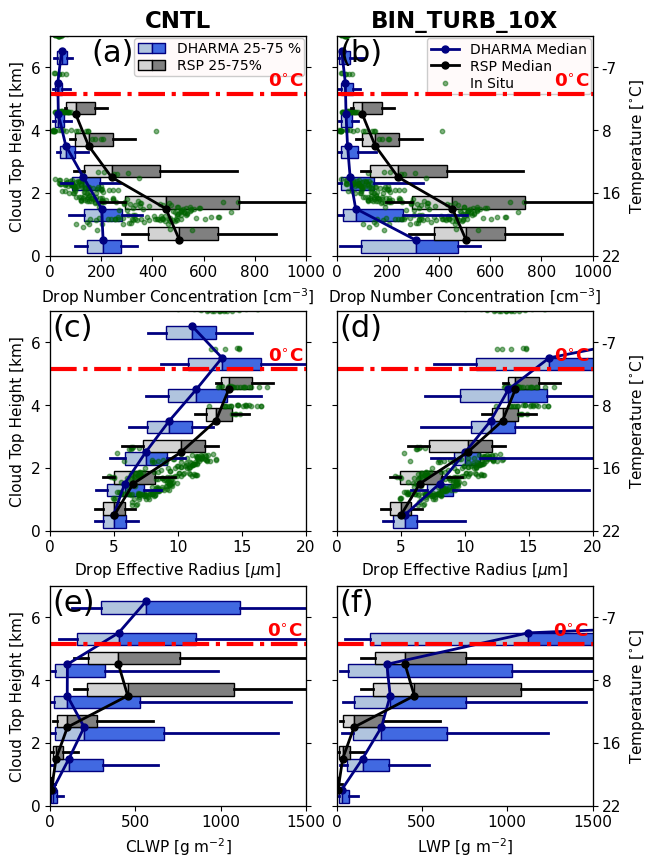

In [30]:
fig = plt.figure(figsize=(7,10))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)
Fontsize=11
axlist = [ax1,ax2,ax3,ax4,ax5,ax6]
for ax in axlist:
    ax.tick_params(labelsize=Fontsize,which='both')
    ax.set_yticks([0,2,4,6])
ax1.set_ylabel('Cloud Top Height [km]',fontsize=Fontsize)
ax3.set_ylabel('Cloud Top Height [km]',fontsize=Fontsize)
ax5.set_ylabel('Cloud Top Height [km]',fontsize=Fontsize)

    
#=================================
# Number concentration
#=================================
var1 = 'ct_qnl_lt_200um'
qn_10 = ct_perc_dict[var1]['10']
qn_90 = ct_perc_dict[var1]['90']
qn_25 = ct_perc_dict[var1]['25']
qn_med = ct_perc_dict[var1]['50']
qn_75 = ct_perc_dict[var1]['75']
qn_mean = ct_perc_dict[var1]['mean']
bin_qn_10 = bin_ct_perc_dict[var1]['10']
bin_qn_90 = bin_ct_perc_dict[var1]['90']
bin_qn_25 = bin_ct_perc_dict[var1]['25']
bin_qn_med = bin_ct_perc_dict[var1]['50']
bin_qn_75 = bin_ct_perc_dict[var1]['75']
bin_qn_mean = bin_ct_perc_dict[var1]['mean']

var1='nd'
rsp_qn_10 = rsp_ct_perc_dict[var1]['10']
rsp_qn_90 = rsp_ct_perc_dict[var1]['90']
rsp_qn_25 = rsp_ct_perc_dict[var1]['25']
rsp_qn_med = rsp_ct_perc_dict[var1]['50']
rsp_qn_75 = rsp_ct_perc_dict[var1]['75']
rsp_qn_mean = rsp_ct_perc_dict[var1]['mean']


dark_color = 'navy'
mid_color = 'royalblue'
light_color = 'lightsteelblue'

for ii in range(len(height_bins)-1):
    

    #--------------------------
    # Number Concentration
    #--------------------------
    ##############
    # DHARMA
    ##############
    # left box
    xx = qn_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = qn_med[ii]-qn_25[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = qn_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = qn_75[ii]-qn_med[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))

    # Add whiskers
    ax1.plot([qn_75[ii],qn_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax1.plot([qn_10[ii],qn_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    ##############
    # DHARMA Bin
    ##############
    # left box
    xx = bin_qn_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = bin_qn_med[ii]-bin_qn_25[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = bin_qn_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = bin_qn_75[ii]-bin_qn_med[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))

    # Add whiskers
    ax2.plot([bin_qn_75[ii],bin_qn_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax2.plot([bin_qn_10[ii],bin_qn_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    ##############
    # RSP
    ##############
    # left box
    xx = rsp_qn_25[ii]
    yy = height_midbins[ii]
    xxsize = rsp_qn_med[ii]-rsp_qn_25[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    # right box
    xx = rsp_qn_med[ii]
    yy = height_midbins[ii]
    xxsize = rsp_qn_75[ii]-rsp_qn_med[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))    
    # Add whiskers
    ax1.plot([rsp_qn_75[ii],rsp_qn_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax2.plot([rsp_qn_75[ii],rsp_qn_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax1.plot([rsp_qn_10[ii],rsp_qn_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    ax2.plot([rsp_qn_10[ii],rsp_qn_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    

ax1.set_xlim(0,1000)
ax2.set_xlim(0,1000)
ax1.set_xlabel('Drop Number Concentration [cm$^{-3}$]',fontsize=Fontsize)
ax2.set_xlabel('Drop Number Concentration [cm$^{-3}$]',fontsize=Fontsize)
ax1.plot(qn_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA Median',markersize=5)
ax2.plot(bin_qn_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA Median',markersize=5)
ax1.plot(rsp_qn_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=5)
ax2.plot(rsp_qn_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=5)

#=================================
# Effective Radius
#=================================
#var2 = 'reff'
var2 = 'ct_reff_l_lt_200um'
reff_c_10 = ct_perc_dict[var2]['10']
reff_c_90 = ct_perc_dict[var2]['90']
reff_c_25 = ct_perc_dict[var2]['25']
reff_c_med = ct_perc_dict[var2]['50']
reff_c_75 = ct_perc_dict[var2]['75']
reff_c_mean = ct_perc_dict[var2]['mean']
bin_reff_c_10 = bin_ct_perc_dict[var2]['10']
bin_reff_c_90 = bin_ct_perc_dict[var2]['90']
bin_reff_c_25 = bin_ct_perc_dict[var2]['25']
bin_reff_c_med = bin_ct_perc_dict[var2]['50']
bin_reff_c_75 = bin_ct_perc_dict[var2]['75']
bin_reff_c_mean = bin_ct_perc_dict[var2]['mean']

var2 = 'Reff'
rsp_reff_c_10 = rsp_ct_perc_dict[var2]['10']
rsp_reff_c_90 = rsp_ct_perc_dict[var2]['90']
rsp_reff_c_25 = rsp_ct_perc_dict[var2]['25']
rsp_reff_c_med = rsp_ct_perc_dict[var2]['50']
rsp_reff_c_75 = rsp_ct_perc_dict[var2]['75']
rsp_reff_c_mean = rsp_ct_perc_dict[var2]['mean']

for ii in range(len(height_bins)-1):
    
    #--------------------------
    # Effective radius
    #--------------------------

    ##############
    # DHARMA
    ##############
    # left box
    xx = reff_c_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = reff_c_med[ii]-reff_c_25[ii]
    yysize = 0.4
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = reff_c_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = reff_c_75[ii]-reff_c_med[ii]
    yysize = 0.4
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))
    # Add whiskers
    ax3.plot([reff_c_75[ii],reff_c_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax3.plot([reff_c_10[ii],reff_c_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    
    ##############
    # DHARMA Bin
    ##############
    # left box
    xx = bin_reff_c_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = bin_reff_c_med[ii]-bin_reff_c_25[ii]
    yysize = 0.4
    ax4.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = bin_reff_c_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = bin_reff_c_75[ii]-bin_reff_c_med[ii]
    yysize = 0.4
    ax4.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))
    # Add whiskers
    ax4.plot([bin_reff_c_75[ii],bin_reff_c_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax4.plot([bin_reff_c_10[ii],bin_reff_c_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    ##############
    # RSP
    ##############
    # left box
    xx = rsp_reff_c_25[ii]
    yy = height_midbins[ii]
    xxsize = rsp_reff_c_med[ii]-rsp_reff_c_25[ii]
    yysize = 0.4
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    ax4.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    # right box
    xx = rsp_reff_c_med[ii]
    yy = height_midbins[ii]
    xxsize = rsp_reff_c_75[ii]-rsp_reff_c_med[ii]
    yysize = 0.4
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))
    ax4.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))    
    
    # Add whiskers
    ax3.plot([rsp_reff_c_75[ii],rsp_reff_c_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax4.plot([rsp_reff_c_75[ii],rsp_reff_c_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax3.plot([rsp_reff_c_10[ii],rsp_reff_c_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    ax4.plot([rsp_reff_c_10[ii],rsp_reff_c_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    

ax3.set_xlim(0,20)
ax4.set_xlim(0,20)
ax3.set_xlabel('Drop Effective Radius [$\\mu$m]',fontsize=Fontsize)
ax4.set_xlabel('Drop Effective Radius [$\\mu$m]',fontsize=Fontsize)
ax3.plot(reff_c_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA Median',markersize=5)
ax4.plot(bin_reff_c_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA Median',markersize=5)
ax3.plot(rsp_reff_c_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=5)
ax4.plot(rsp_reff_c_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=5)


#=================================
# LWP
#=================================
var3 = 'clwp'
#var3 = 'lwp'
var4 = 'lwp'
lwp_10 = ct_perc_dict[var3]['10']
lwp_90 = ct_perc_dict[var3]['90']
lwp_25 = ct_perc_dict[var3]['25']
lwp_med = ct_perc_dict[var3]['50']
lwp_75 = ct_perc_dict[var3]['75']
lwp_mean = ct_perc_dict[var3]['mean']
bin_lwp_10 = bin_ct_perc_dict[var4]['10']
bin_lwp_90 = bin_ct_perc_dict[var4]['90']
bin_lwp_25 = bin_ct_perc_dict[var4]['25']
bin_lwp_med = bin_ct_perc_dict[var4]['50']
bin_lwp_75 = bin_ct_perc_dict[var4]['75']
bin_lwp_mean = bin_ct_perc_dict[var4]['mean']

var3 = 'lwp'
rsp_lwp_10 = rsp_ct_perc_dict[var3]['10']
rsp_lwp_90 = rsp_ct_perc_dict[var3]['90']
rsp_lwp_25 = rsp_ct_perc_dict[var3]['25']
rsp_lwp_med = rsp_ct_perc_dict[var3]['50']
rsp_lwp_75 = rsp_ct_perc_dict[var3]['75']
rsp_rlwp_mean = rsp_ct_perc_dict[var3]['mean']

for ii in range(len(height_bins)-1):
    
    #--------------------------
    # Effective radius
    #--------------------------

    ##############
    # DHARMA
    ##############
    # left box
    xx = lwp_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = lwp_med[ii]-lwp_25[ii]
    yysize = 0.4
    ax5.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = lwp_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = lwp_75[ii]-lwp_med[ii]
    yysize = 0.4
    ax5.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))
    # Add whiskers
    ax5.plot([lwp_75[ii],lwp_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax5.plot([lwp_10[ii],lwp_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    
    ##############
    # DHARMA Bin
    ##############
    # left box
    xx = bin_lwp_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = bin_lwp_med[ii]-bin_lwp_25[ii]
    yysize = 0.4
    ax6.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = bin_lwp_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = bin_lwp_75[ii]-bin_lwp_med[ii]
    yysize = 0.4
    ax6.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))
    # Add whiskers
    ax6.plot([bin_lwp_75[ii],bin_lwp_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax6.plot([bin_lwp_10[ii],bin_lwp_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    ##############
    # RSP
    ##############
    # left box
    xx = rsp_lwp_25[ii]
    yy = height_midbins[ii]
    xxsize = rsp_lwp_med[ii]-rsp_lwp_25[ii]
    yysize = 0.4
    ax5.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    ax6.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    # right box
    xx = rsp_lwp_med[ii]
    yy = height_midbins[ii]
    xxsize = rsp_lwp_75[ii]-rsp_lwp_med[ii]
    yysize = 0.4
    ax5.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))
    ax6.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))    
    
    # Add whiskers
    ax5.plot([rsp_lwp_75[ii],rsp_lwp_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax6.plot([rsp_lwp_75[ii],rsp_lwp_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax5.plot([rsp_lwp_10[ii],rsp_lwp_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    ax6.plot([rsp_lwp_10[ii],rsp_lwp_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    

ax5.set_xlim(0,1500)
ax6.set_xlim(0,1500)
#ax5.set_xlabel('LWP [g m$^{-2}$]',fontsize=Fontsize)
ax5.set_xlabel('CLWP [g m$^{-2}$]',fontsize=Fontsize)
ax6.set_xlabel('LWP [g m$^{-2}$]',fontsize=Fontsize)
ax5.plot(lwp_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA Median',markersize=5)
ax6.plot(bin_lwp_med,height_midbins,lw=2,marker='o',c=dark_color,label='DHARMA Median',markersize=5)
ax5.plot(rsp_lwp_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=5)
ax6.plot(rsp_lwp_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=5)


for ax in axlist:
    ax.set_ylim(height_bins[0],height_bins[-1])
    
# Plot CTT on first subplot
ax1a = ax1.twinx()
ax2a = ax2.twinx()
ax1b = ax1.twiny()
ax2b = ax2.twiny()
ax2a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax1a.yaxis.labelpad = 5
ax2a.yaxis.labelpad = 5
ax1b.plot(rsp_qn_mean_interp,height_bins,marker='D',alpha=0.)
ax2b.plot(rsp_qn_mean_interp,height_bins,marker='D',alpha=0.)
ax1b.set_xticks([])
ax2b.set_xticks([])
dum_yticks = ax1.get_yticks()
ax1a.set_yticks(dum_yticks)
ax2a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
#ax1a.set_yticklabels(dum_yticks2)
ax1a.set_yticklabels([])
ax2a.set_yticklabels(dum_yticks2)
ax1a.tick_params(labelsize=Fontsize,which='both',pad=3)
ax2a.tick_params(labelsize=Fontsize,which='both',pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax1.tick_params(axis='x',pad=3)
ax2.tick_params(axis='x',pad=3)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax1a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax2a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax1a.set_ylim(height_bins[0],height_bins[-1])
ax2a.set_ylim(height_bins[0],height_bins[-1])
ax2.set_yticklabels([])

# Plot CTT on second subplot
ax3a = ax3.twinx()
ax4a = ax4.twinx()
ax3b = ax3.twiny()
ax4b = ax4.twiny()
ax4a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax3a.yaxis.labelpad = 5
ax4a.yaxis.labelpad = 5
ax3b.plot(rsp_reff_l_mean_interp,height_bins,marker='D',alpha=0.)
ax4b.plot(rsp_reff_l_mean_interp,height_bins,marker='D',alpha=0.)
ax3b.set_xticks([])
ax4b.set_xticks([])
dum_yticks = ax3.get_yticks()
ax4a.set_yticks(dum_yticks)
ax3a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
#ax3a.set_yticklabels(dum_yticks2)
ax3a.set_yticklabels([])
ax4a.set_yticklabels(dum_yticks2)
ax3a.tick_params(labelsize=Fontsize,which='both',pad=3)
ax4a.tick_params(labelsize=Fontsize,which='both',pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax3.tick_params(axis='x',pad=3)
ax4.tick_params(axis='x',pad=3)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax3a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax4a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax3a.set_ylim(height_bins[0],height_bins[-1])
ax4a.set_ylim(height_bins[0],height_bins[-1])
ax4.set_yticklabels([])

# Plot CTT on third subplot
ax5a = ax5.twinx()
ax6a = ax6.twinx()
ax5b = ax5.twiny()
ax6b = ax6.twiny()
ax6a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax5a.yaxis.labelpad = 5
ax6a.yaxis.labelpad = 5
ax5b.plot(rsp_lwp_mean_interp,height_bins,marker='D',alpha=0.)
ax6b.plot(rsp_lwp_mean_interp,height_bins,marker='D',alpha=0.)
ax5b.set_xticks([])
ax6b.set_xticks([])
dum_yticks = ax5.get_yticks()
ax6a.set_yticks(dum_yticks)
ax5a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
#ax3a.set_yticklabels(dum_yticks2)
ax5a.set_yticklabels([])
ax6a.set_yticklabels(dum_yticks2)
ax5a.tick_params(labelsize=Fontsize,which='both',pad=3)
ax6a.tick_params(labelsize=Fontsize,which='both',pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax5.tick_params(axis='x',pad=3)
ax6.tick_params(axis='x',pad=3)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax5a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax6a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax5a.set_ylim(height_bins[0],height_bins[-1])
ax6a.set_ylim(height_bins[0],height_bins[-1])
ax6.set_yticklabels([])


dumx=0.01
dumy=0.99
ax1.text(dumx+0.15,dumy,'(a)',transform=ax1.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax2.text(dumx,dumy,'(b)',transform=ax2.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax3.text(dumx,dumy,'(c)',transform=ax3.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax4.text(dumx,dumy,'(d)',transform=ax4.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax5.text(dumx,dumy,'(e)',transform=ax5.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax6.text(dumx,dumy,'(f)',transform=ax6.transAxes,fontsize=Fontsize*2.,va='top',ha='left')

ax1.text(850,zero_height+0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold',zorder=100)
ax2.text(850,zero_height+0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold',zorder=100)
ax3.text(17,zero_height+0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold',zorder=100)
ax4.text(17,zero_height+0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold',zorder=100)
ax5.text(1270,zero_height+0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold',zorder=100)
ax6.text(1270,zero_height+0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold',zorder=100)


#ax1.text(0.99,1.10,'DHARMA N='+str(int(dharma_samp_size)),fontsize=Fontsize*1.25,fontweight='bold',c=dark_color,transform=ax1.transAxes,ha='right',va='bottom')
#ax2.text(0.99,1.01,'RSP N='+str(int(rsp_samp_size)),fontsize=Fontsize*1.25,fontweight='bold',c='k',transform=ax1.transAxes,ha='right',va='bottom')


ax1.scatter(ffssp_dict['conc']*1.e-3,ffssp_dict['alt'],c='darkgreen',s=10,alpha=0.5,label='In Situ')
ax2.scatter(ffssp_dict['conc']*1.e-3,ffssp_dict['alt'],c='darkgreen',s=10,alpha=0.5,label='In Situ')
ax3.scatter(ffssp_dict['reff'],ffssp_dict['alt'],c='darkgreen',s=10,alpha=0.5)
ax4.scatter(ffssp_dict['reff'],ffssp_dict['alt'],c='darkgreen',s=10,alpha=0.5)

#lgnd = ax2.legend(framealpha=True,loc='upper right',bbox_to_anchor=(1.02,1.02),labelspacing=0.2,borderpad=0.3,facecolor='floralwhite')
#lgnd = ax2.legend(framealpha=False,loc='upper right',bbox_to_anchor=(1.02,1.02),labelspacing=0.2)
#lgnd.get_frame().set_edgecolor('k')

#ax1.legend(framealpha=False,loc='upper right',bbox_to_anchor=(1.35,1.25),labelspacing=0.2)

#lgnd1 = ax2.legend(framealpha=False,loc='upper right',bbox_to_anchor=(1.04,1.03),labelspacing=0.2)
lgnd1 = ax2.legend(framealpha=True,loc='upper right',bbox_to_anchor=(1.02,1.02),labelspacing=0.2,borderpad=0.3,facecolor='snow')

colors1 = ['lightgrey','grey']
edgecolor1 = 'black'
colors2 = [light_color,mid_color]
edgecolor2 = dark_color

patch1 = MulticolorPatch(colors1,edgecolor1)
patch2 = MulticolorPatch(colors2,edgecolor2)
h = [patch2,patch1]
l = ['DHARMA 25-75 %','RSP 25-75%']

lgnd2 = ax1.legend(h, l, loc='upper right', 
         handler_map={MulticolorPatch: MulticolorPatchHandler()}, 
         bbox_to_anchor=(1.02,1.02),framealpha=True,labelspacing=0.2,borderpad=0.25,facecolor='snow')

#ax2.add_artist(lgnd1)

ax1.set_title('CNTL',fontsize=Fontsize*1.5,fontweight='bold')
ax2.set_title('BIN_TURB_10X',fontsize=Fontsize*1.5,fontweight='bold')

plt.subplots_adjust(hspace=0.25,wspace=0.12)

fig_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
outfile = 'cntl_bin_turb_10x_rsp_ffssp_profiles.png'
#plt.savefig(fig_path+outfile,dpi=300,bbox_inches='tight')
plt.show()
plt.close()  